In [ ]:
import numpy as np
from pymystem3 import Mystem
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import nltk
import pickle
import csv
import math
import datetime, os
from scipy.sparse import csr_matrix
 
import gc
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
 
!pip3 install tensorboardx
from tensorboardX import SummaryWriter
 
CUDA = torch.cuda.device_count()
device = 'cuda'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/datasets/ad_dataset ./

In [ ]:
!ls -la /content/drive/MyDrive/datasets/ad_dataset

In [ ]:


class ad_dataset(Dataset):
    def __init__(self, path):
        with open(path, "rb") as f:
            samples = pickle.load(f)
        self.samples = np.array(samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        sample = self.samples[index]
        return sample

    def get_mean_var_estimation(self):
        print(self.samples.shape)
        bs, seq_len, feature_size = self.samples.shape
        mean = np.mean(self.samples.reshape(bs,seq_len),axis=0)
        var = np.var(self.samples.reshape(bs,seq_len),axis=0)
        return mean, var



train_normal = ad_dataset("ad_dataset/train_0")
test_normal = ad_dataset("ad_dataset/test_0")
test_anomaly = ad_dataset("ad_dataset/test_1")
validation1_normal = ad_dataset("ad_dataset/validation1_0")
validation2_normal = ad_dataset("ad_dataset/validation2_0")
validation_anomaly = ad_dataset("ad_dataset/validation_1")

In [ ]:
L = 3
HIDDEN = 128
NUM_LAYERS = 1

class LSTM_AD(nn.Module):

    def __init__(self, hidden_size, num_layers, target_size, seq_len=140):
        super(LSTM_AD, self).__init__()
        
        self.target_size = target_size
        self.expand = nn.Linear(1, hidden_size)
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True)

        self.hidden2target = nn.Linear( hidden_size, target_size)

        self.loss_func = nn.MSELoss()

        self.loss_indices = dict()
        self.error_indices = dict()
        if CUDA:
          self.cuda()

    def forward(self, batch_measurements):
        #batch_measurements = torch.transpose(batch_measurements, 0, 1) 
        batch_measurements = self.expand(batch_measurements)
        lstm_out, _ = self.lstm(batch_measurements)
        predicted = self.hidden2target(lstm_out)
        return predicted

    def error_estimation(self, predicted,real):
        # real: (Batch_size, seq_len, 1)
        # looks like nnot needed,
        bs = real.size(0)
        seq_len = real.size(1)
        L = self.target_size

          
        print(real.size())
        print(predicted.size())
          #indices_for_one = np.array([ind[L - i - 1 : seq_len - i] for i in range(L)]).reshape(-1)
        real_indices_for_one = np.array(sum([list(range(L,seq_len)) for i in range(L)],[]))
        real_seq_indices_for_batch = np.tile(real_indices_for_one, bs)
        print(real_seq_indices_for_batch, seq_len)

          #(seq_len-L+1) - len of sub sequens for one L, 
          #L times for 1 sequence in batch
          #bs size times for batch 
        
        batch_indices = np.arange(bs).repeat(real_indices_for_one.shape[0])
        print(batch_indices)

        predicted_seq_indices_for_batch = np.tile(np.array(sum([list(range(L-1-i,seq_len -1 - i)) for i in range(L)],[])), bs)
        print(predicted_seq_indices_for_batch)
        predicted_last_indices = np.tile(np.array(sum([[i for _ in range(seq_len-L)] for i in range(L)],[])), bs)
        print(predicted_last_indices)




        real = real[batch_indices, 
                    real_seq_indices_for_batch, 
                    np.zeros(real_seq_indices_for_batch.shape[0])]
        real = real.view(bs,seq_len-L, L)
        
        predicted = predicted[batch_indices, 
                              predicted_seq_indices_for_batch, 
                              predicted_last_indices]
        predicted = predicted.view(bs,seq_len-L, L)
        
        err = real - predicted
        print("err",err.size())

        
        return err, torch.mean(err, dim=(0,2)), torch.var(err,dim=(0,2))

    def loss(self, predicted, real):
        # real: (Batch_size, seq_len, 1)
        # looks like nnot needed,
        #print(real.size())
        #print(predicted.size())
        bs = real.size(0)
        seq_len = real.size(1)
        L = self.target_size

        if (bs, seq_len) in self.loss_indices:
          real_seq_indices_for_batch, batch_indices, predicted_seq_indices_for_batch, predicted_last_indices = self.loss_indices[(bs, seq_len)]

        else:
          
          print(real.size())
          print(predicted.size())
          #indices_for_one = np.array([ind[L - i - 1 : seq_len - i] for i in range(L)]).reshape(-1)
          real_indices_for_one = np.array(sum([list(range(i+1,seq_len)) for i in range(L)],[]))
          real_seq_indices_for_batch = np.tile(real_indices_for_one, bs)
          print(real_seq_indices_for_batch, seq_len)

          #(seq_len-L+1) - len of sub sequens for one L, 
          #L times for 1 sequence in batch
          #bs size times for batch 
          
          batch_indices = np.arange(bs).repeat(real_indices_for_one.shape[0])
          print(batch_indices)

          predicted_seq_indices_for_batch = np.tile(np.array(sum([list(range(0,seq_len  - 1 - i)) for i in range(L)],[])), bs)
          print(predicted_seq_indices_for_batch)
          predicted_last_indices = np.tile(np.array(sum([[i for _ in range(seq_len - 1 - i)] for i in range(L)],[])), bs)
          print(predicted_last_indices)

          
          self.loss_indices[(bs, seq_len)] = (real_seq_indices_for_batch, 
                                              batch_indices,
                                              predicted_seq_indices_for_batch,
                                              predicted_last_indices)


        real = real[batch_indices, 
                    real_seq_indices_for_batch, 
                    np.zeros(real_seq_indices_for_batch.shape[0])]
        real = real.view(bs,-1)
        
        predicted = predicted[batch_indices, 
                              predicted_seq_indices_for_batch, 
                              predicted_last_indices]
        predicted = predicted.view(bs, -1)

        return self.loss_func(predicted, real)
        

_BS = 2
seq_len=7
feature_count = 1
input = torch.arange(_BS*seq_len*feature_count).view(_BS, seq_len, feature_count).float()
if CUDA:
  input = input.cuda()
#print(input)
lstm = LSTM_AD(HIDDEN, NUM_LAYERS, L)
print(input.size())
out = lstm(input)
lstm.loss(out, input).backward()
lstm.error_estimation(out,input)
print(out.size())


LSTM_AD(
  (expand): Linear(in_features=1, out_features=128, bias=True)
  (lstm): LSTM(128, 128, batch_first=True)
  (hidden2target): Linear(in_features=128, out_features=5, bias=True)
  (loss_func): MSELoss()
)
torch.Size([32, 140, 1])
torch.Size([32, 140, 5])
[  1   2   3 ... 137 138 139] 140
[ 0  0  0 ... 31 31 31]
[  0   1   2 ... 132 133 134]
[0 0 0 ... 4 4 4]
iteration 999 loss: 0.0005699856556020677
(32, 140, 5)


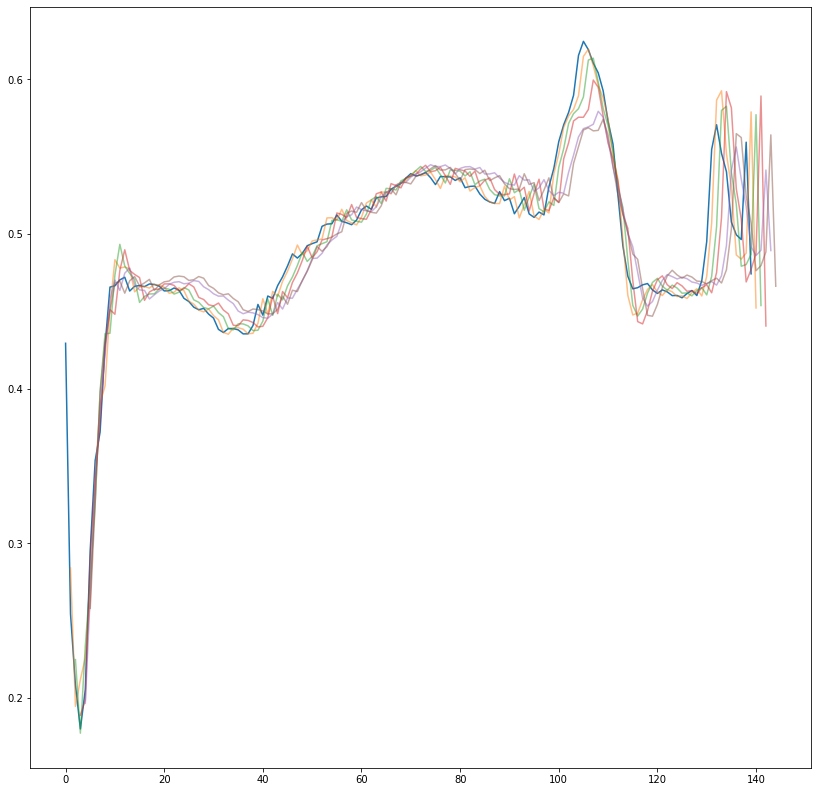

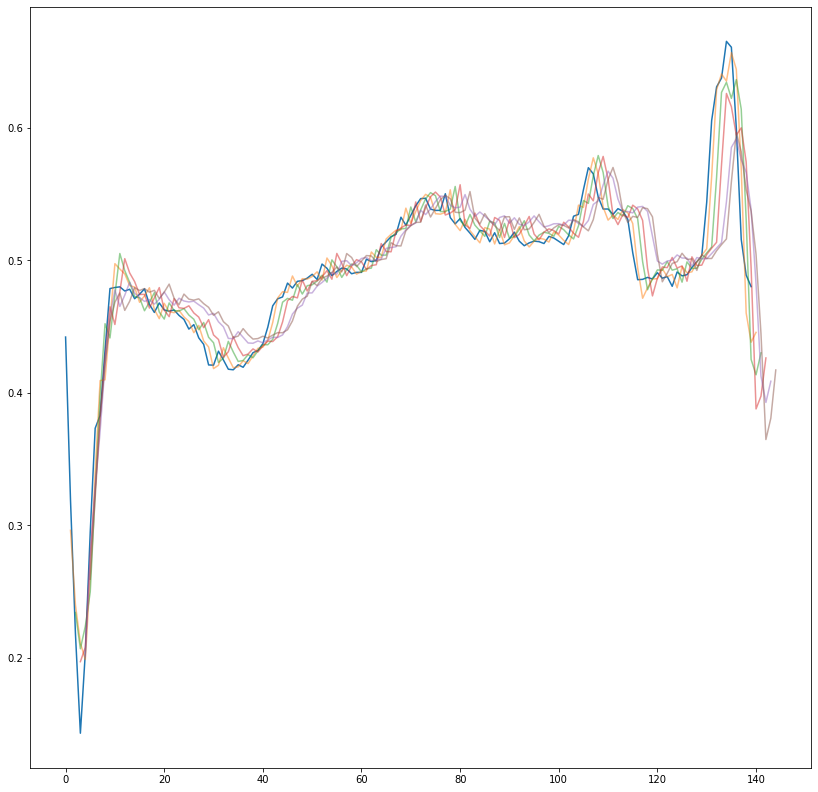

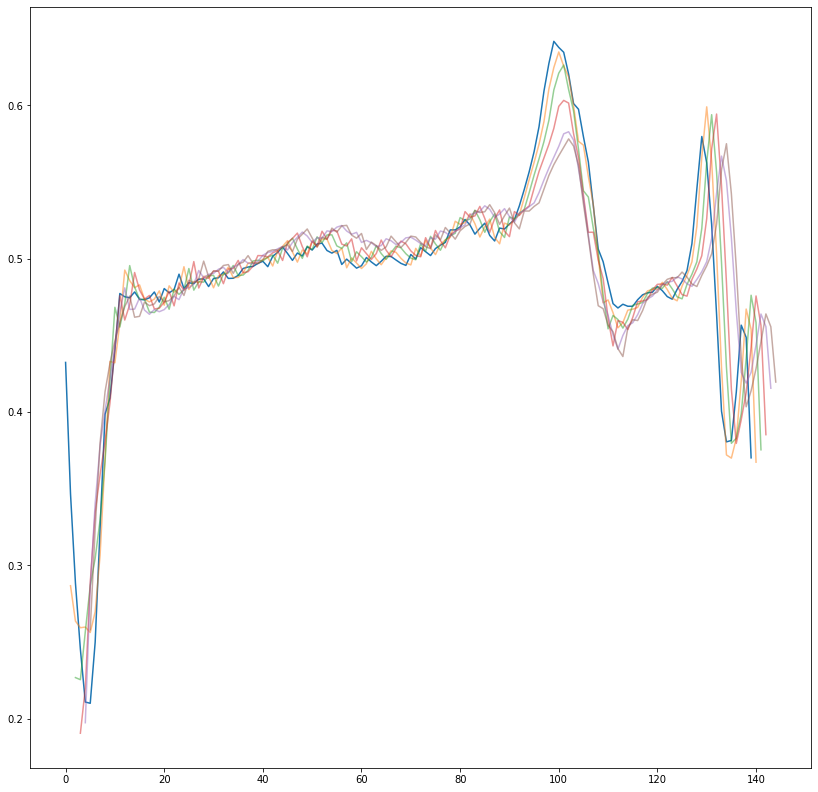

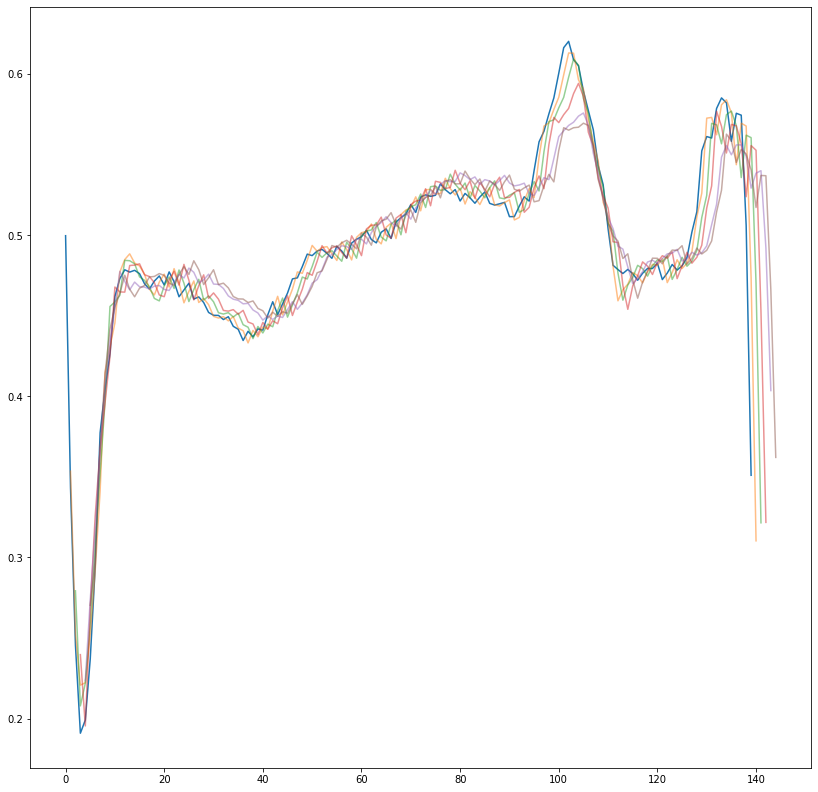

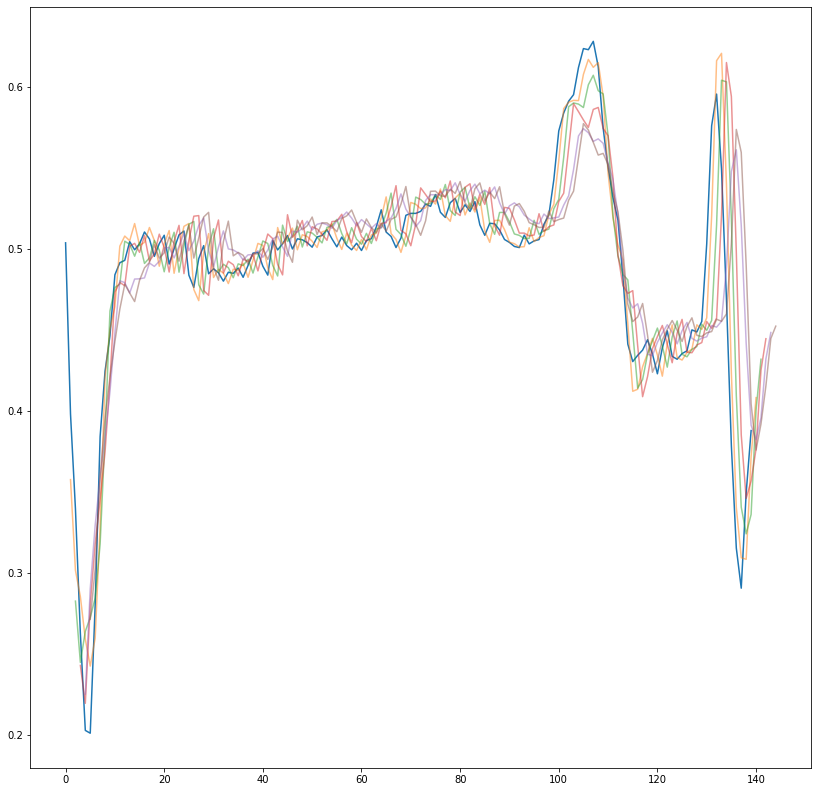

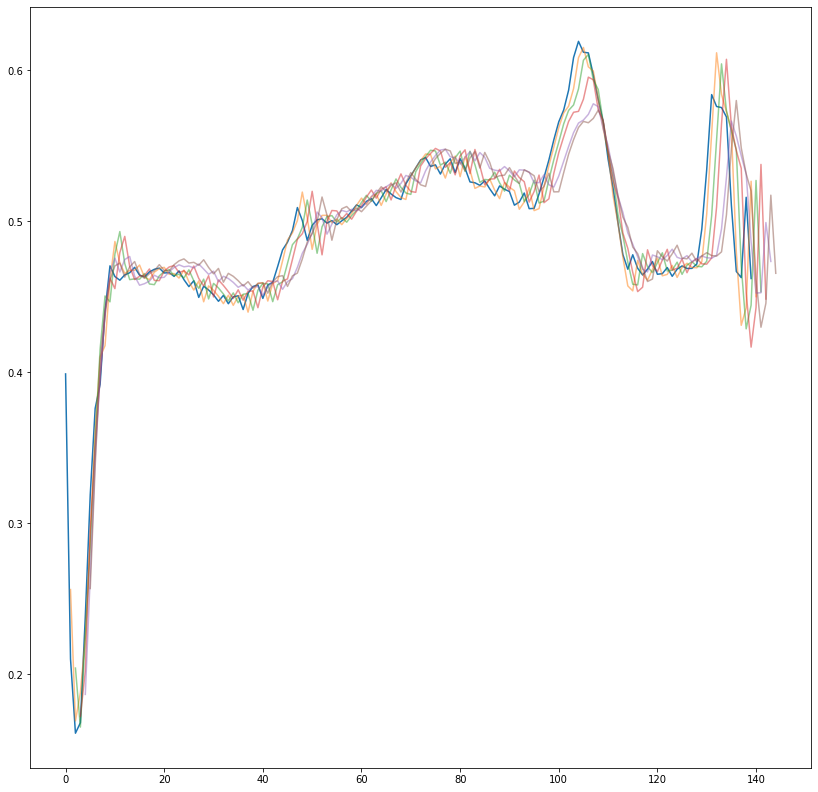

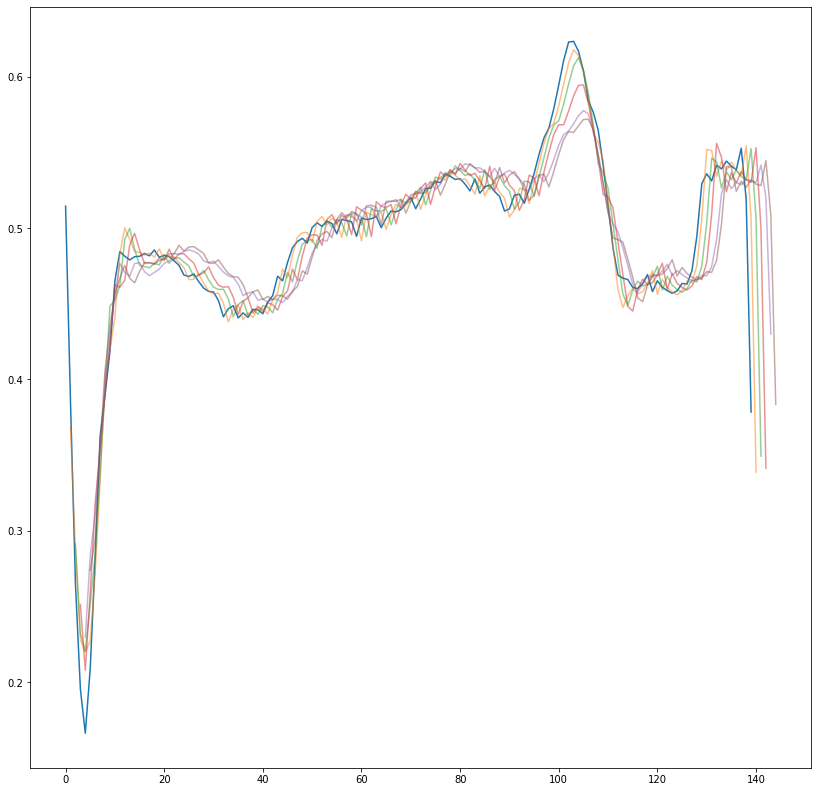

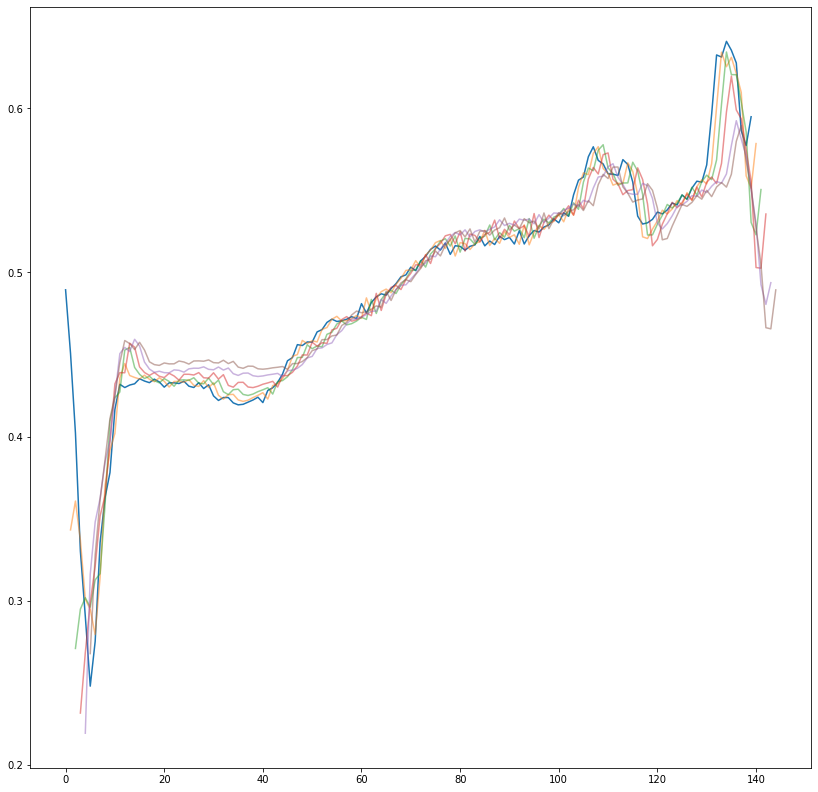

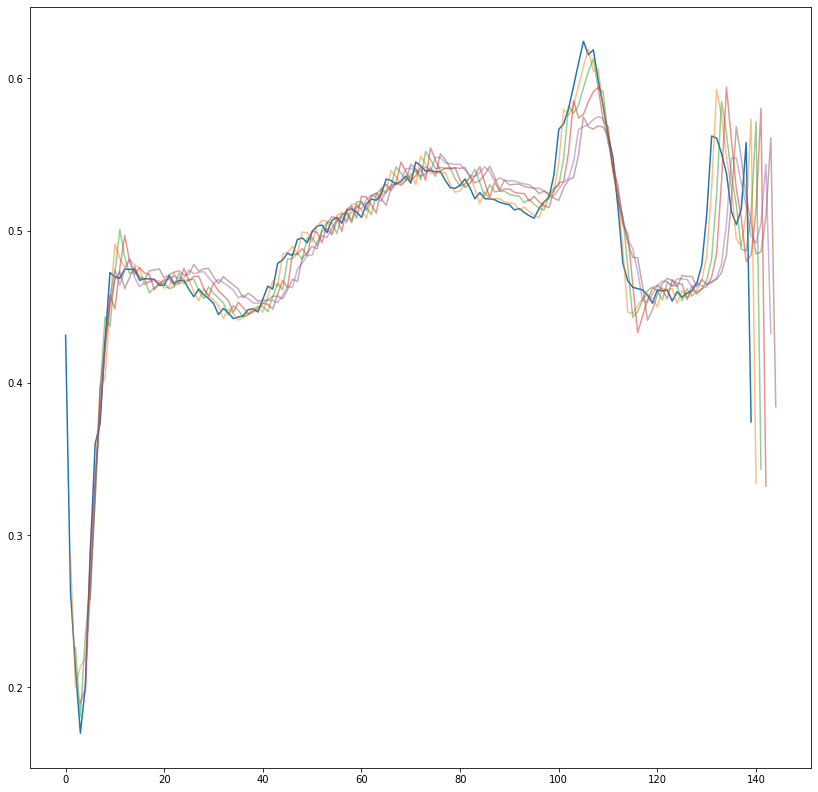

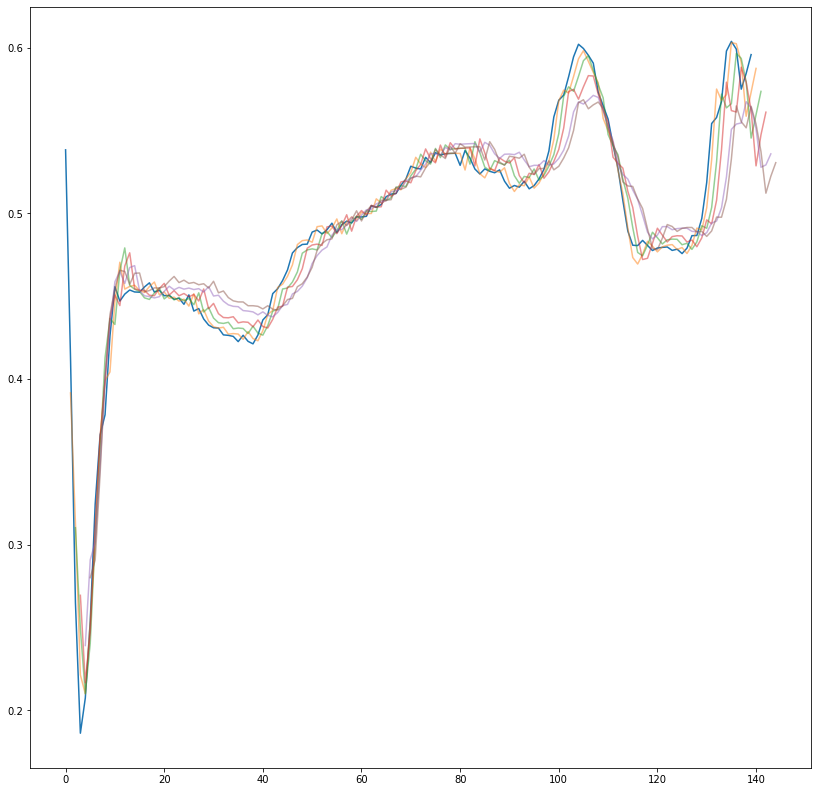

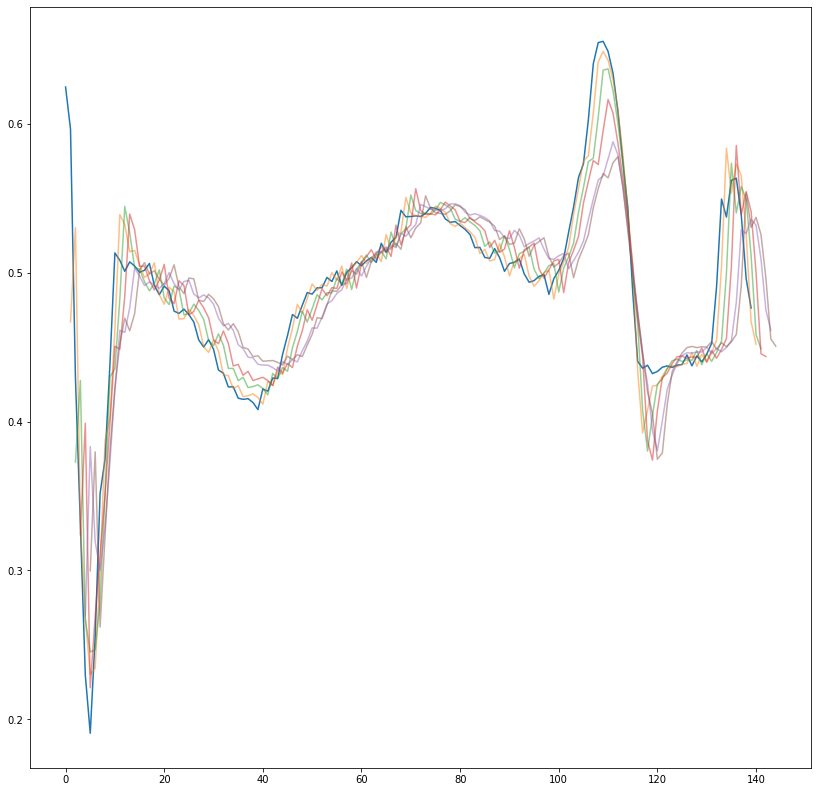

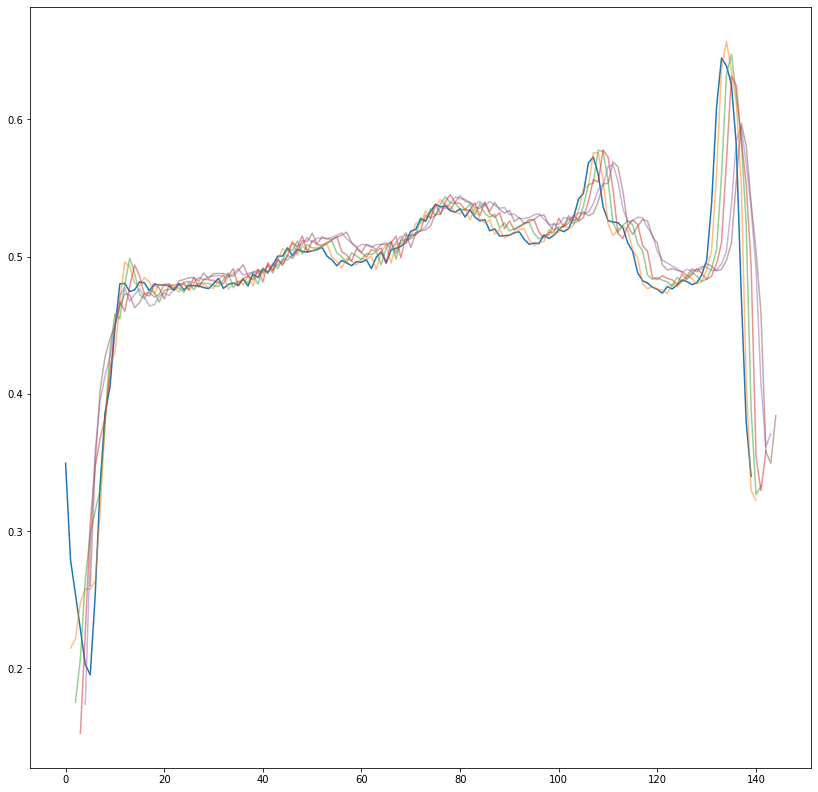

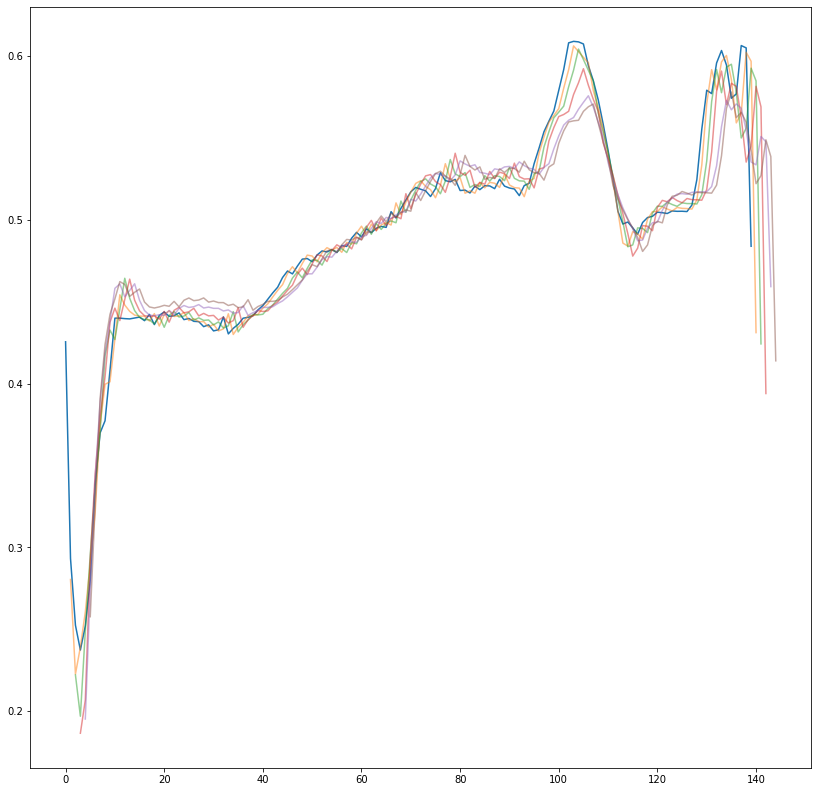

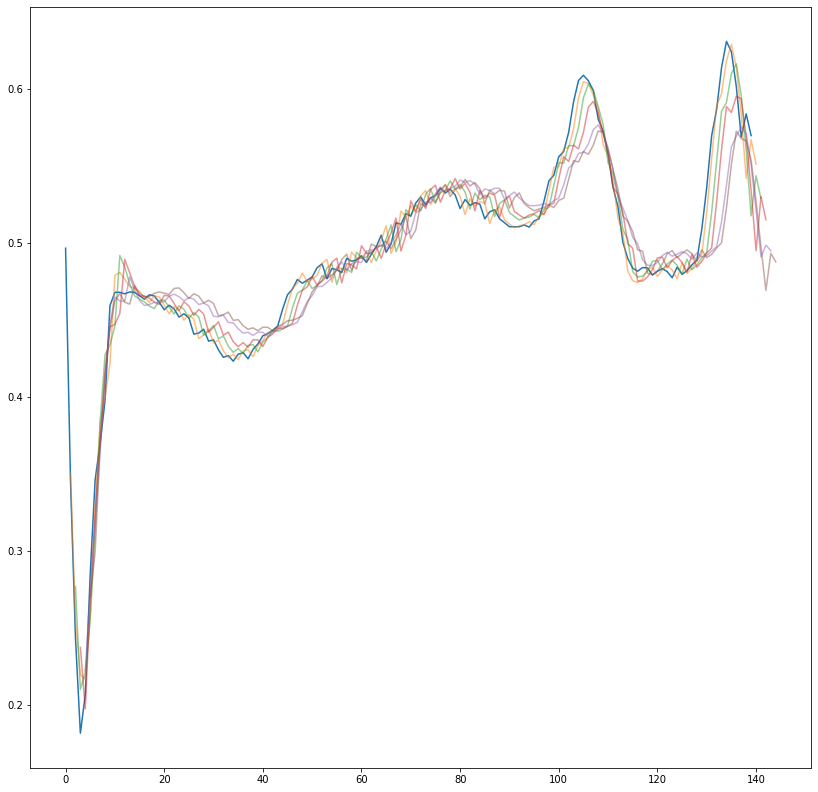

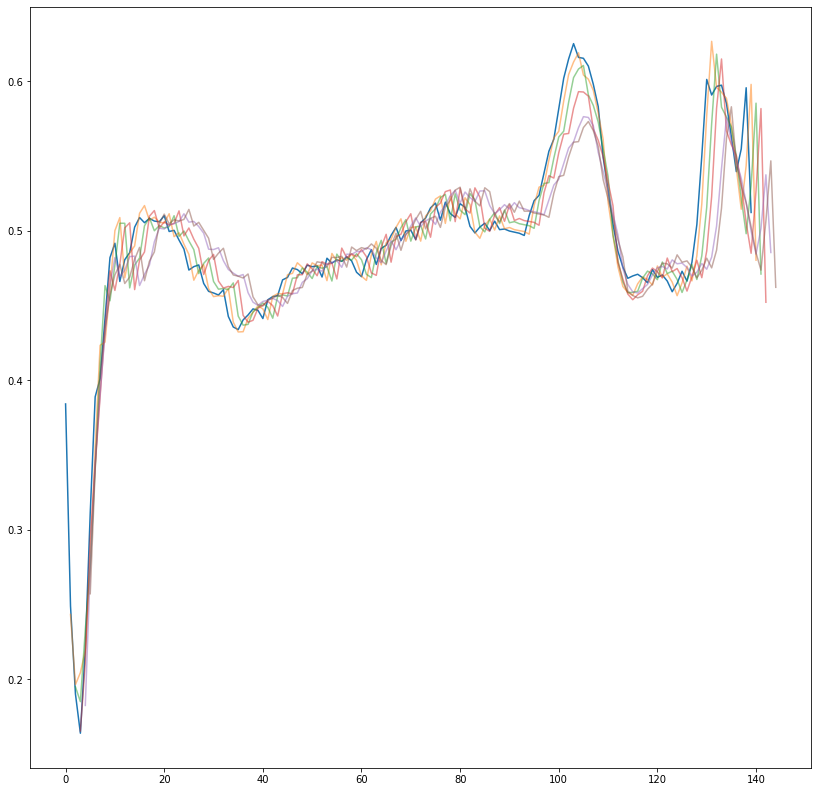

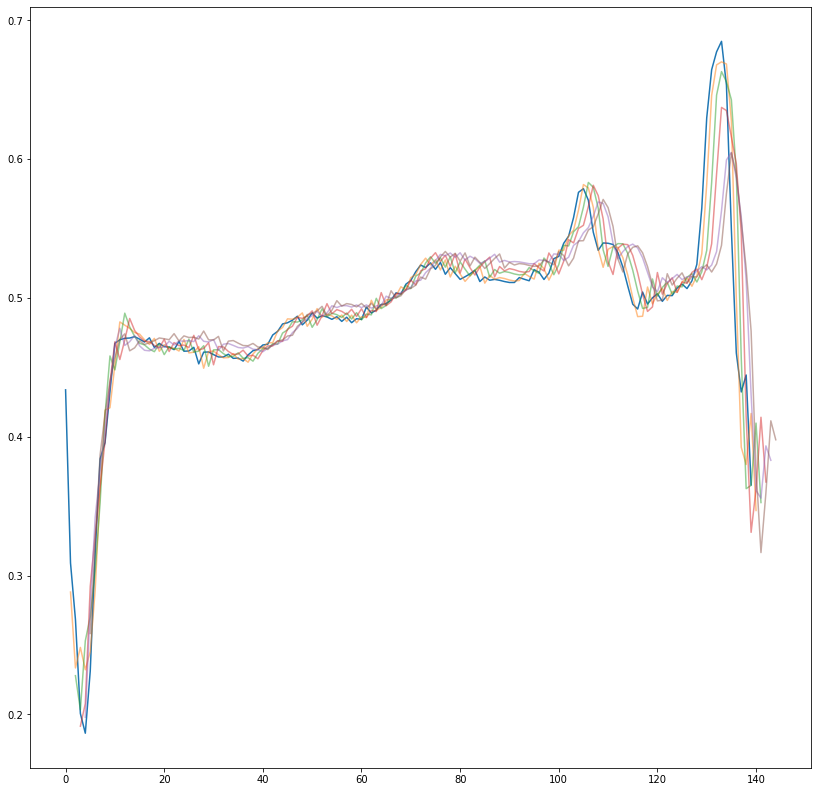

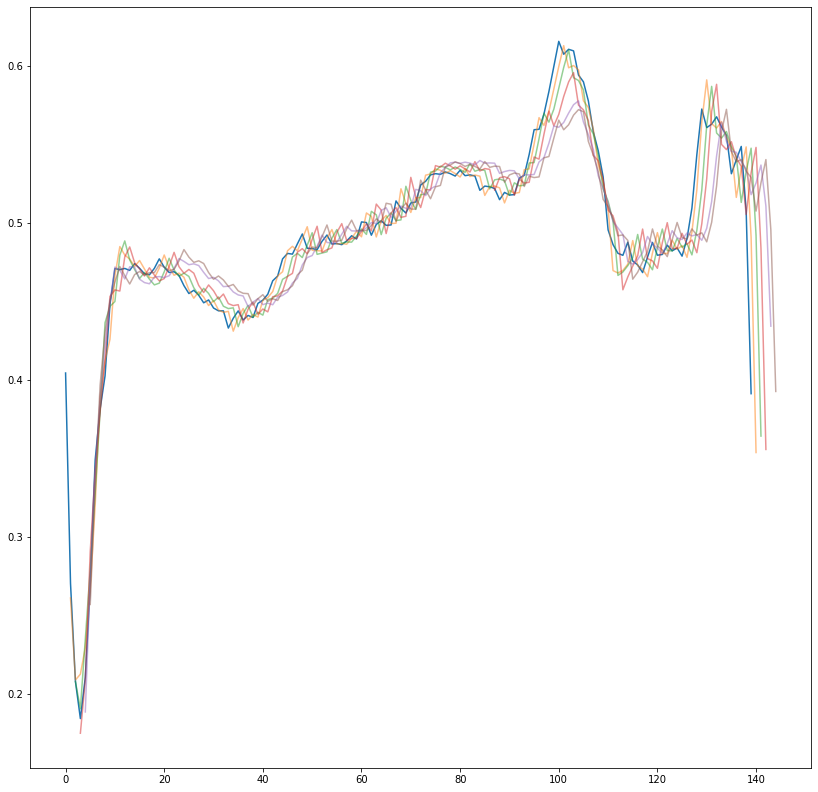

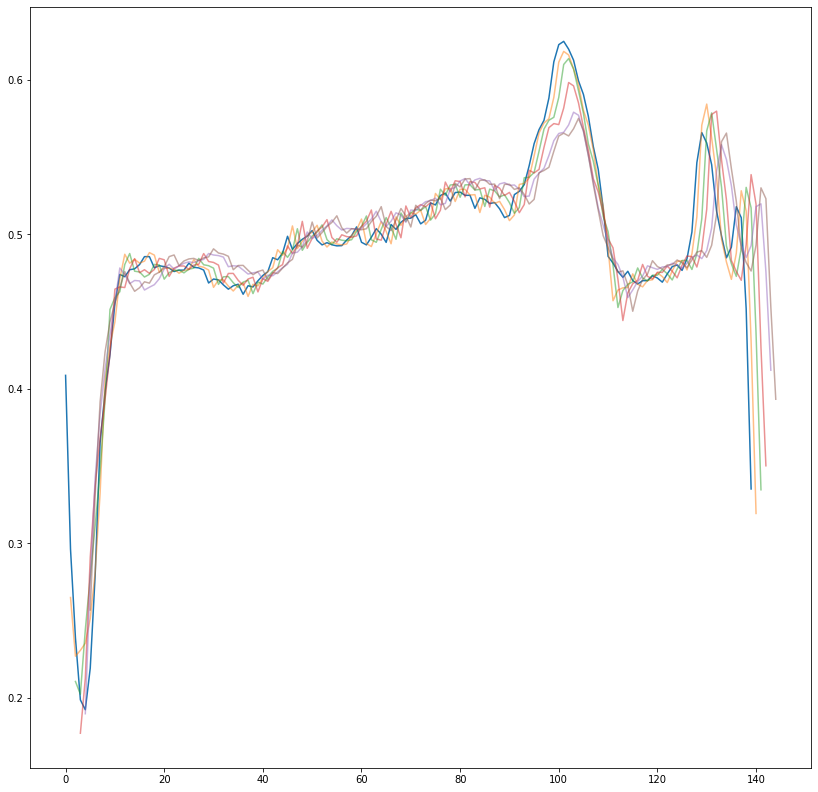

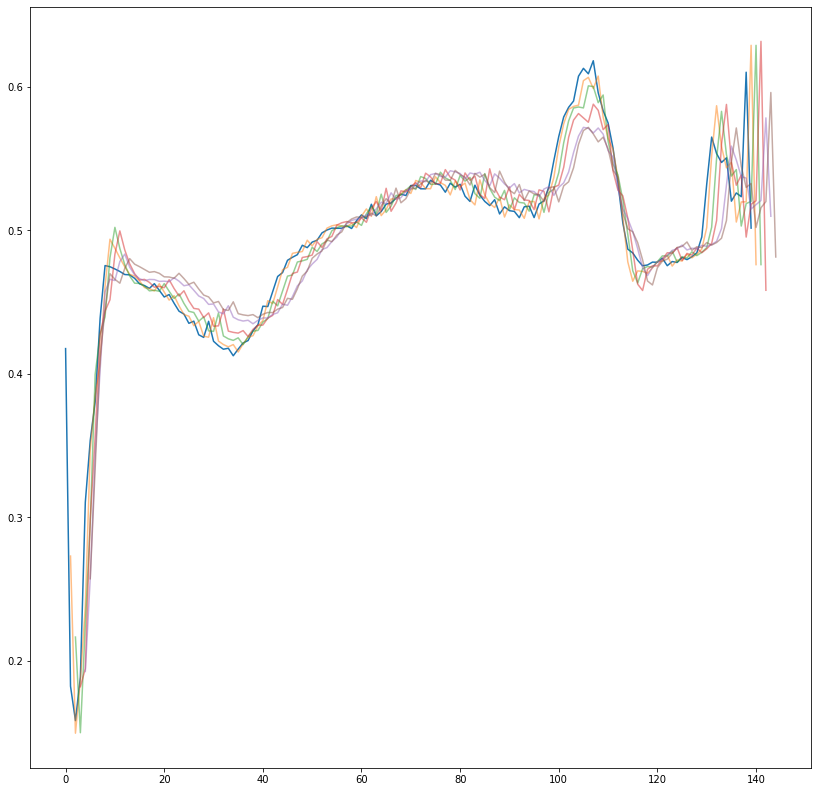

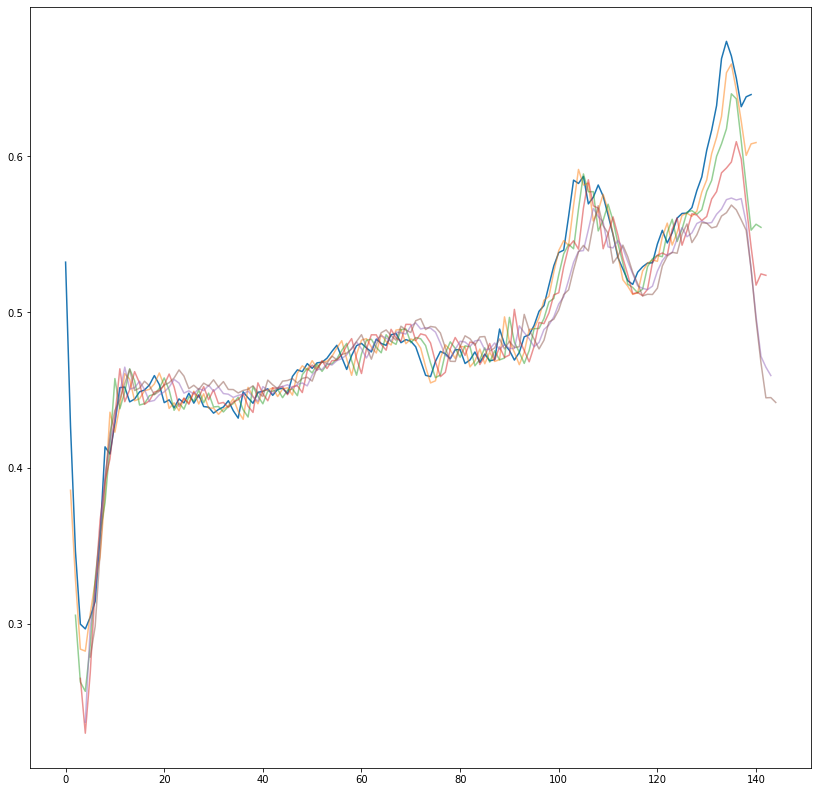

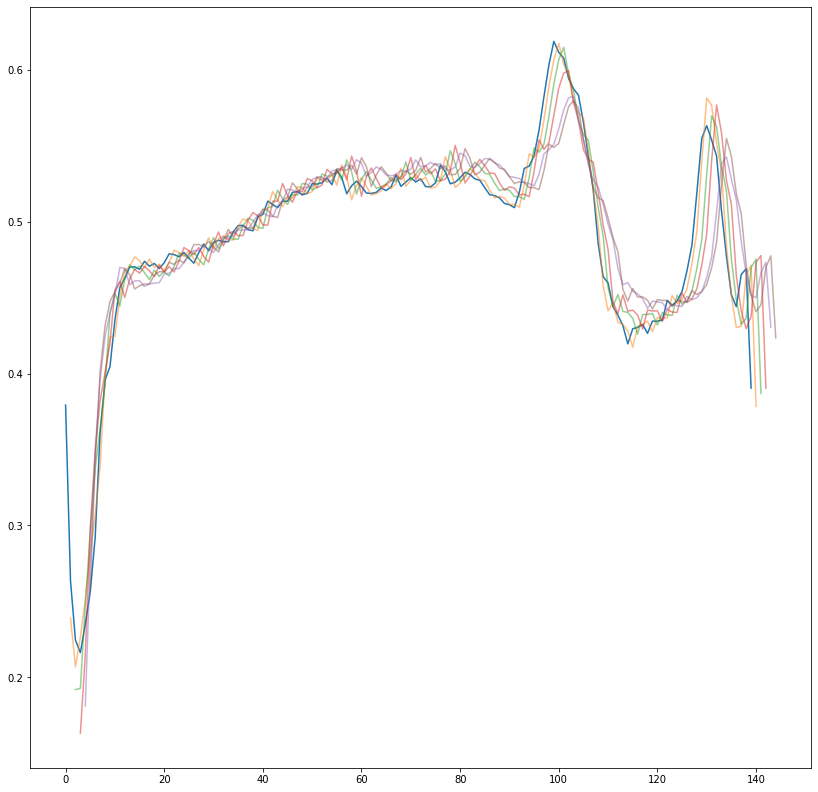

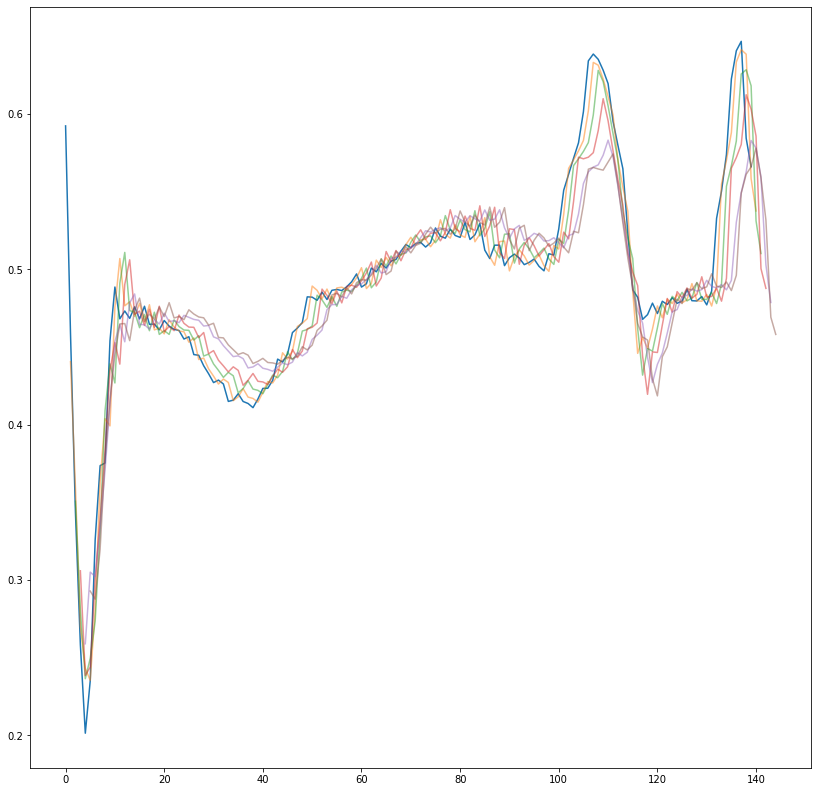

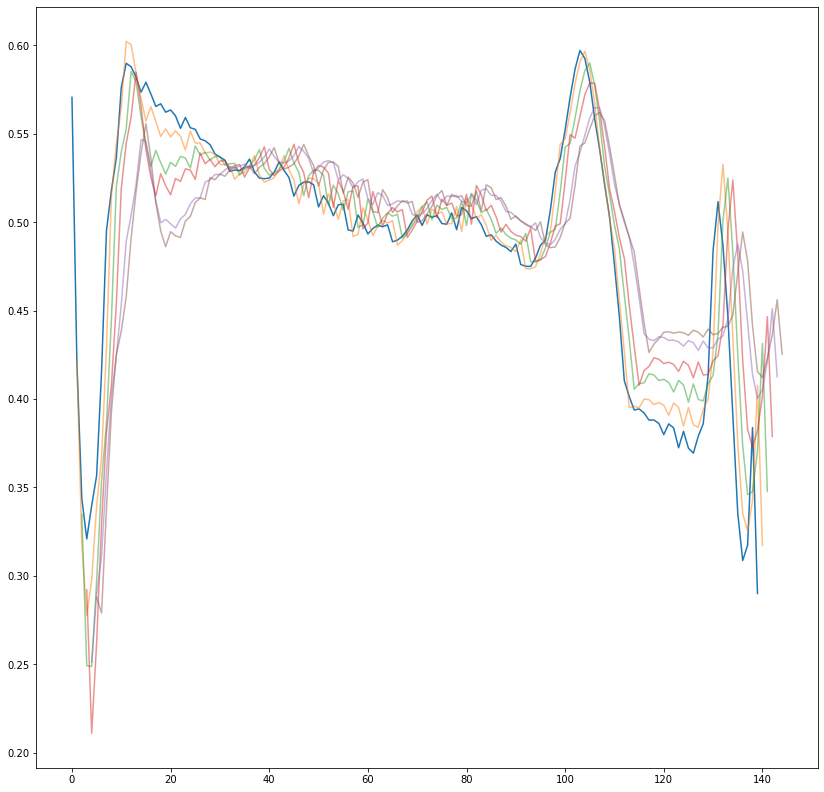

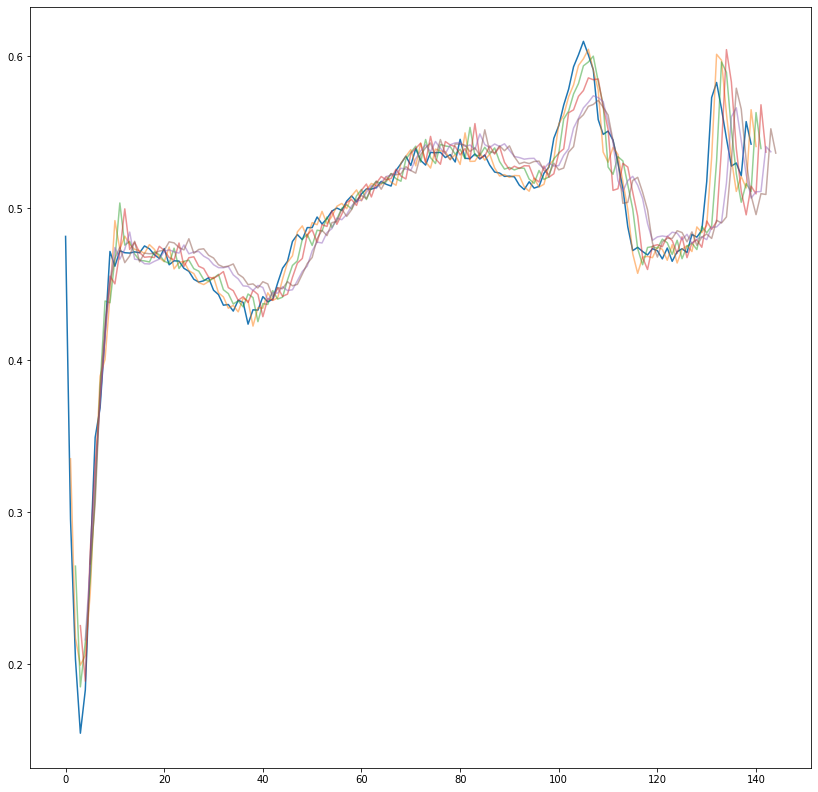

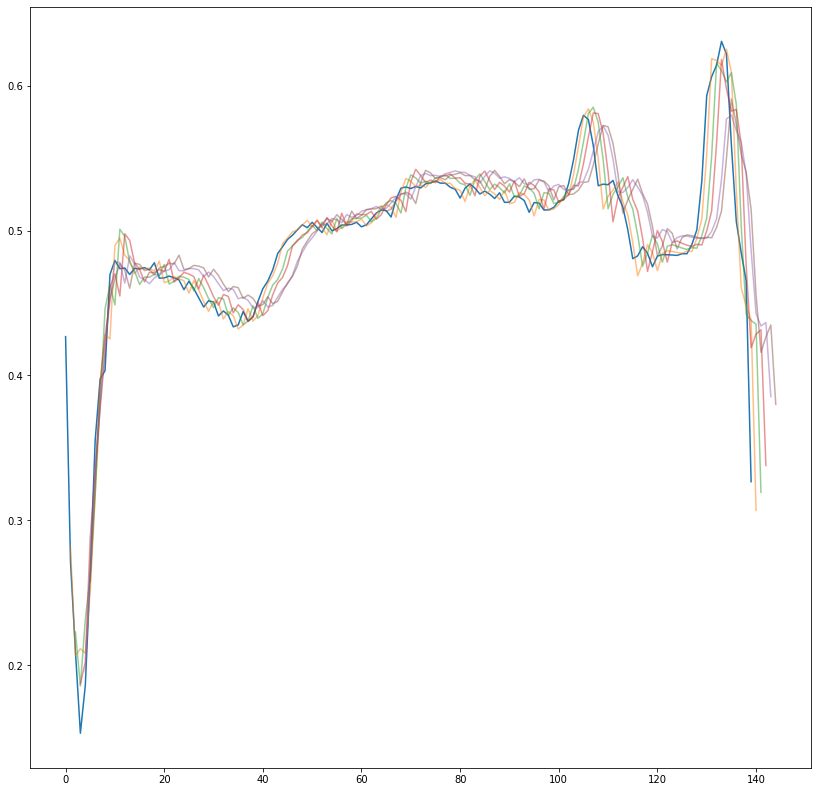

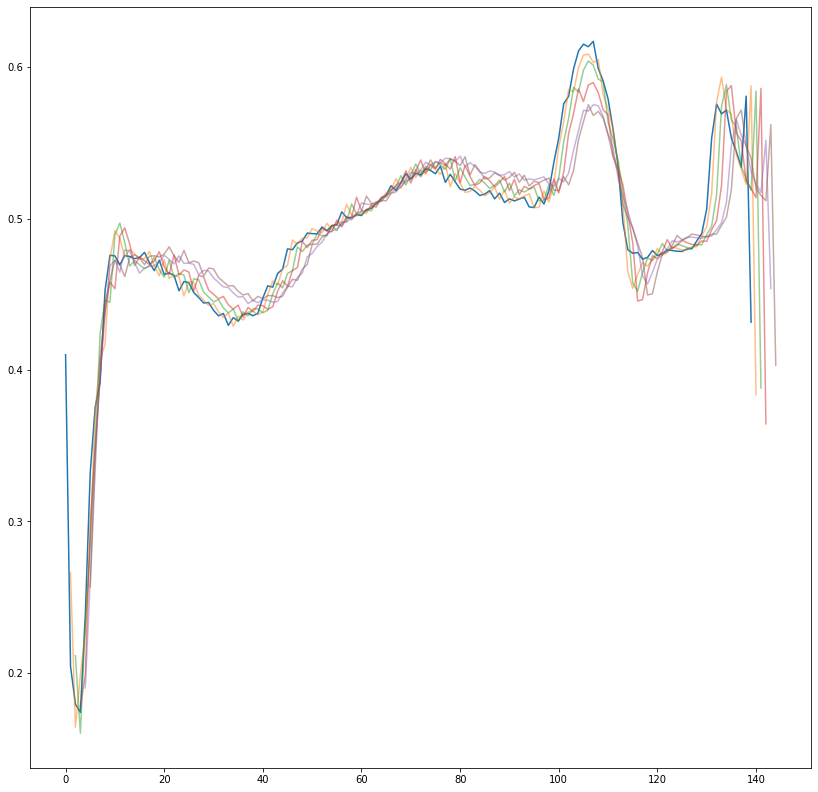

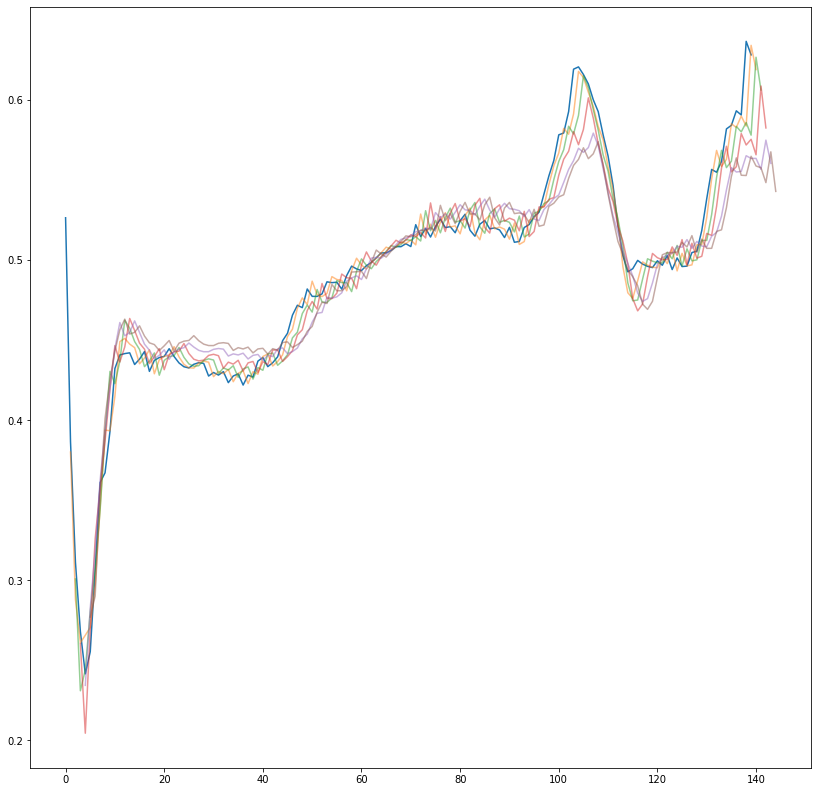

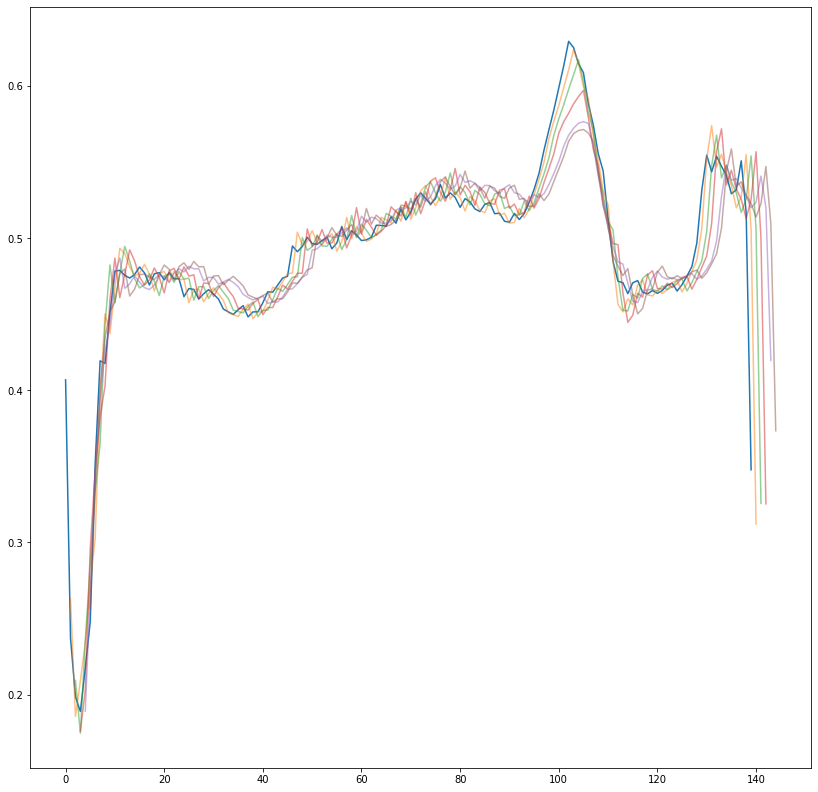

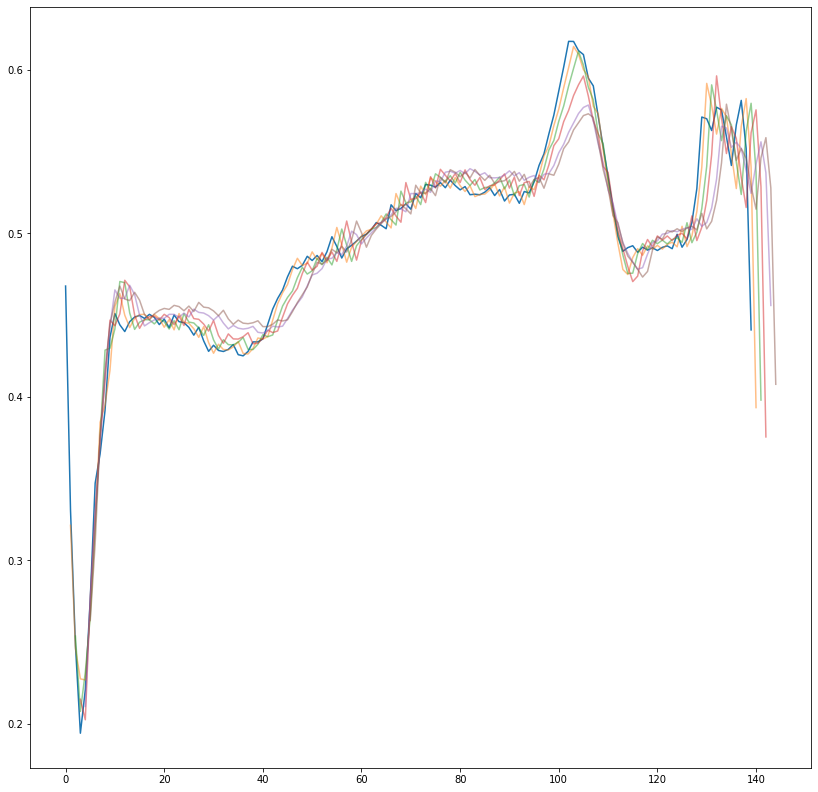

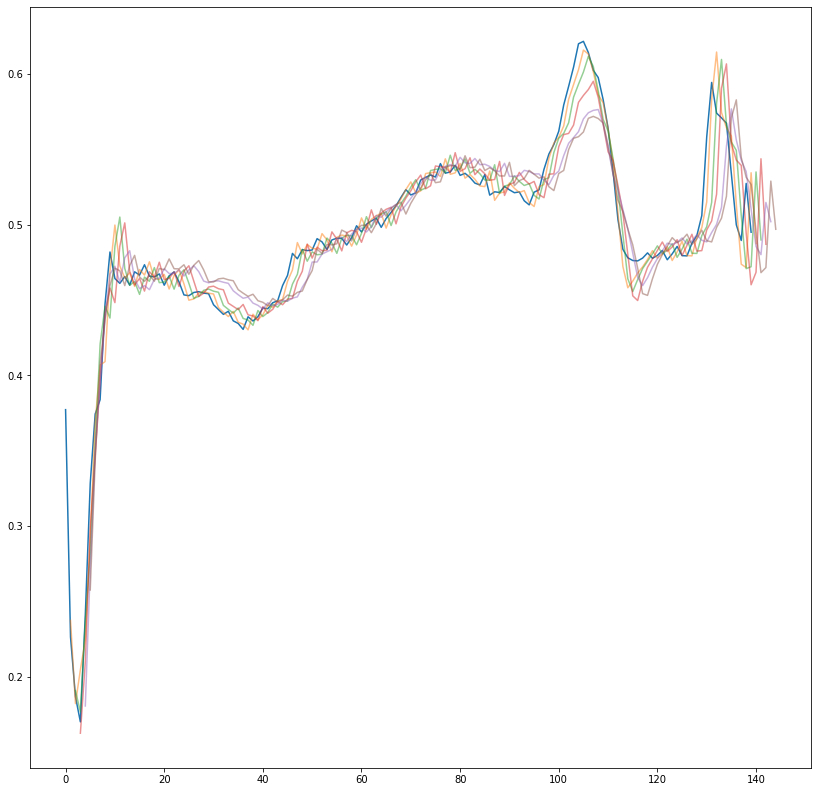

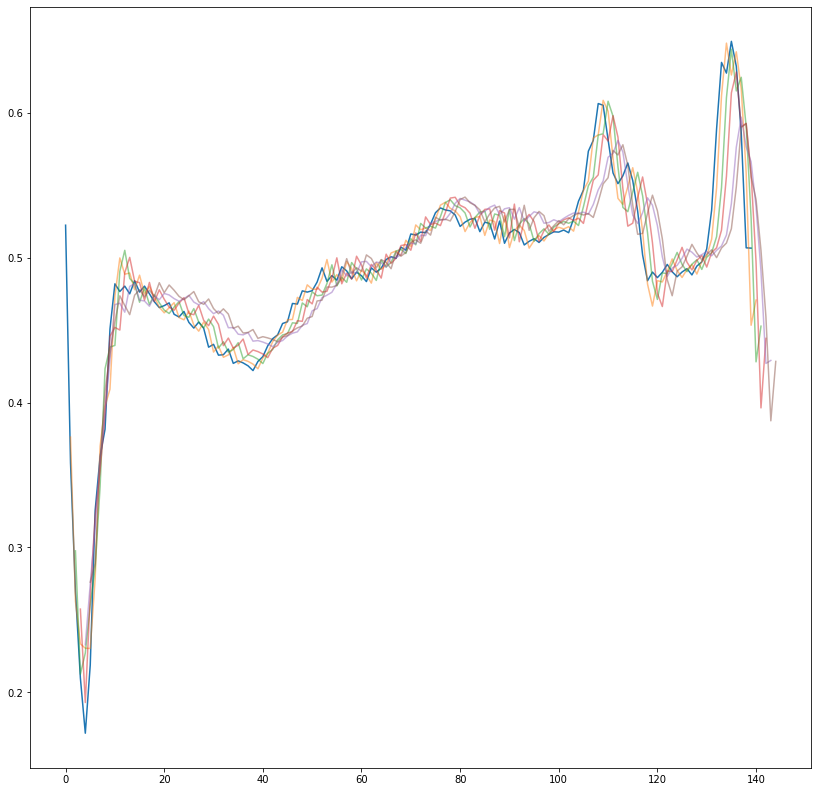

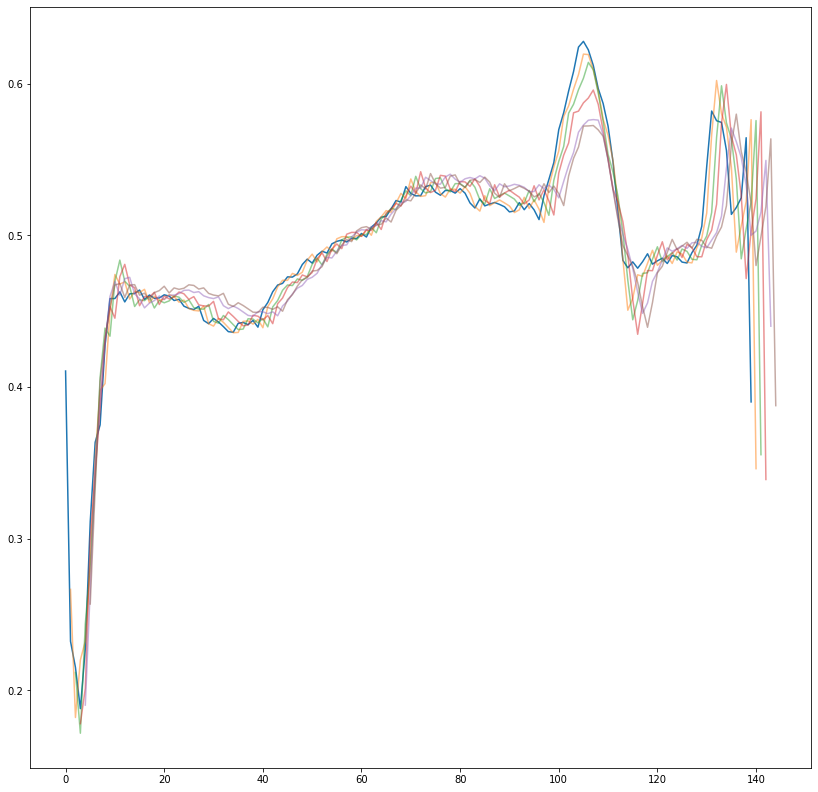

In [ ]:
gc.collect()
SAVE_MODEL = True
def one_batch_overfit():
    train_loader = DataLoader(dataset=train_normal, batch_size=32, shuffle=True)

    model =  LSTM_AD(HIDDEN, NUM_LAYERS, L)
    print(model)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #sched =  MyWarmupCosineAnnealingLR(optimizer,linear_lr_m, T_max, eta_min=eta_min, sin_max=SIN_MAX, last_epoch=-1)


    train_losses = []
    t_loss = 100000
    batch = iter(train_loader).next().float()
    if CUDA:
      batch = batch.cuda()
    i=1
    while t_loss>0 and i<1000:
        optimizer.zero_grad()
            


        outputs = model(batch)
        loss = model.loss(outputs, batch)
        loss.backward()

        optimizer.step()
        #sched.step()

        train_losses.append(loss.item())
        t_loss=train_losses[-1]
        print(f"\riteration {i} loss: {train_losses[-1]}", end='')
        i+=1
    print()
    train_pred = outputs.detach().cpu().numpy()

    batch = batch.detach().cpu().numpy()
    print(train_pred.shape)
    _L = train_pred.shape[2]
    seq_len = train_pred.shape[1]

    for index in range(train_pred.shape[0]):
      plt.figure(figsize=(14, 14))
      plt.plot(batch[index])
      if 0:
        for i in range(0, seq_len - _L, 2):
          plt.plot(np.arange(i,i + _L)+1, train_pred[index,i,:])
      else:
        for l in range(0,L):
          plt.plot(np.arange(0, seq_len)+1+l, train_pred[index, :, l].reshape(-1), alpha=0.5)
      plt.show()



one_batch_overfit()

In [ ]:
gc.collect()
BS = 512
SAVE_MODEL = True
def learn_model():
    train_loader = DataLoader(dataset=train_normal, batch_size=BS, shuffle=True)
    test_loader = DataLoader(dataset=validation1_normal, batch_size=BS, shuffle=False)

    model =  LSTM_AD(HIDDEN, NUM_LAYERS, L)
    print(model)
    print(f"Train dataset size: {len(train_loader)}")
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    #sched =  MyWarmupCosineAnnealingLR(optimizer,linear_lr_m, T_max, eta_min=eta_min, sin_max=SIN_MAX, last_epoch=-1)
    

    mean_train_losses = []
    mean_test_losses = []
    test_acc_list = []
    train_acc_list = []
    epochs = 1000
    best_loss = 100000

    writer = SummaryWriter(logdir='/content/drive/My Drive/datasets/runs/ad/{}'.format(datetime.datetime.now().strftime("%B_%d_%Y_%H_%M")))

    for epoch in range(epochs):
        print(f"epoch: {epoch}/{epochs}")

        model.train()

        train_losses = []
        iter_count = len(train_loader)
        average_loss = 0
        k = 0
        for i, target in enumerate(train_loader):
            optimizer.zero_grad()
            
            target = target.float()
            if CUDA:
                target = target.cuda()

            outputs = model(target)
            loss = model.loss(outputs, target)
            loss.backward()

            optimizer.step()

            train_losses.append(loss.item())
            average_loss = (average_loss*k + train_losses[-1]) / (k + 1)
            k += 1
            print(f"\r\ttrain iteration {i}/{iter_count} loss: {train_losses[-1]} average_loss={average_loss}", end='')
            
        writer.add_scalars('Total/Loss', {'train': average_loss}, epoch)
        #sched.step()
        print()
        
        with torch.no_grad():
            test_losses = []
            k = 0
            test_average_loss = 0
            iter_count = len(test_loader)
            for i, target in enumerate(test_loader):
                
                target = target.float()
                if CUDA:
                    target = target.cuda()
                outputs = model(target)
                loss = model.loss(outputs, target)
              
                test_losses.append(loss.item())

                test_average_loss = (average_loss*k + train_losses[-1]) / (k + 1)
                k+= 1
                print(f"\r\tvalid ititeration {i}/{iter_count} loss: {test_losses[-1]} average_loss={test_average_loss}", end='')

        if SAVE_MODEL and test_average_loss < best_loss:
            PATH = "/content/drive/My Drive/datasets/ad_lstm_ad.model"
            torch.save(model, PATH) # {balanced_test_acc[-1]}
            best_loss = test_average_loss
            print(f"\nModel was dumped to {PATH} loss={average_loss}")

        print()




if __name__ == "__main__":
    #compute_dataset()
    learn_model()

--------------------
(5, 140, 5)


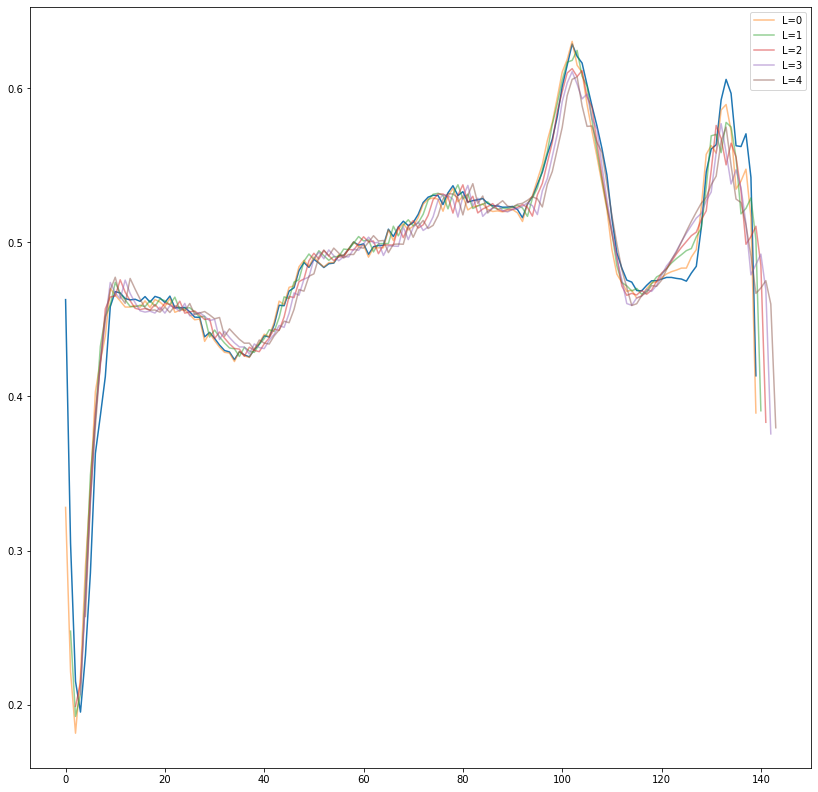

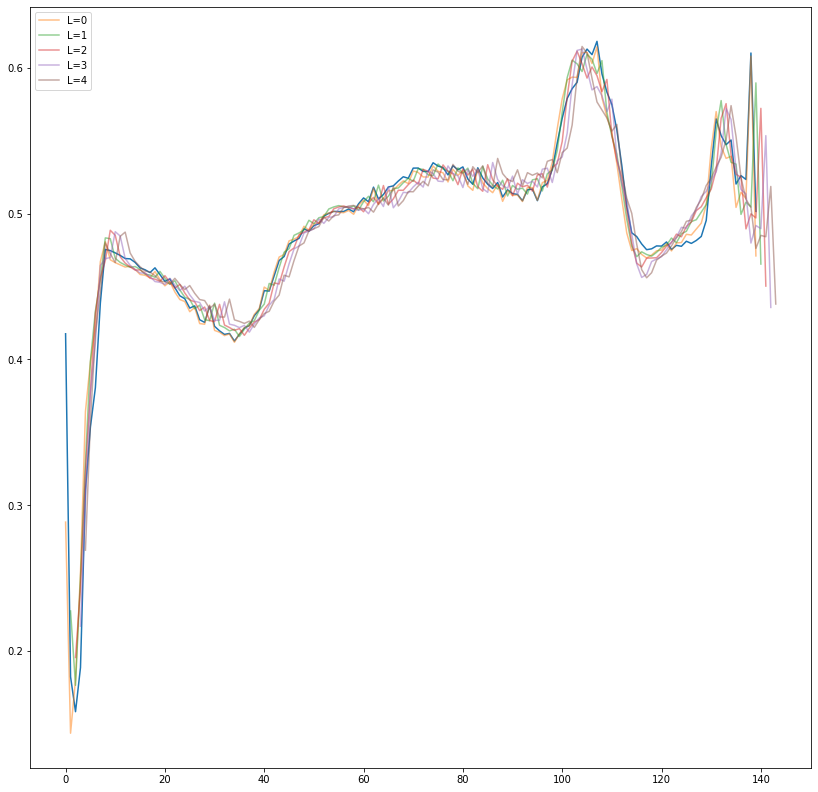

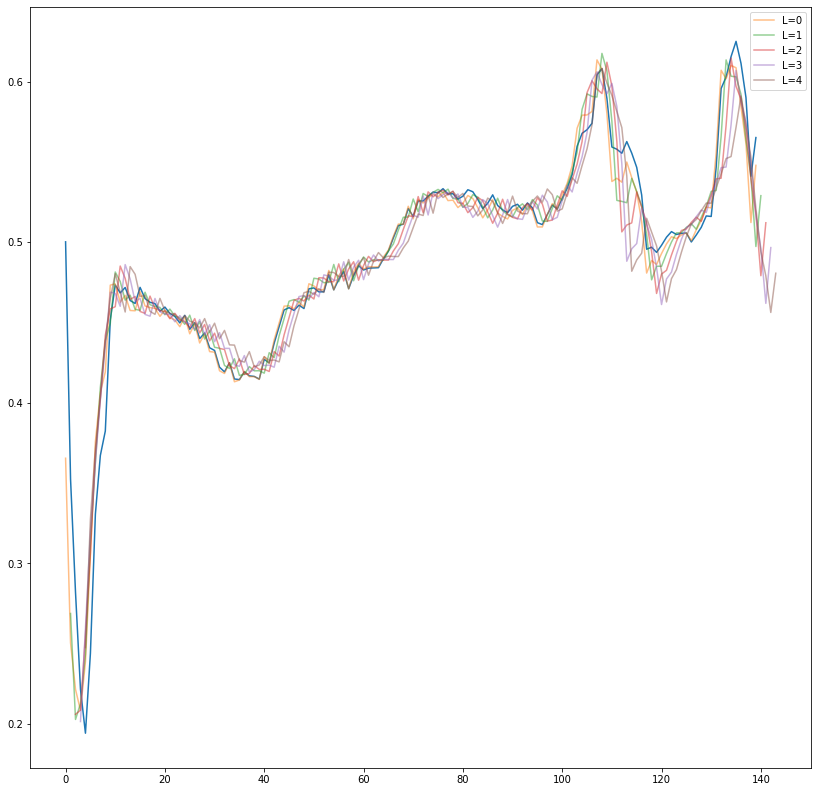

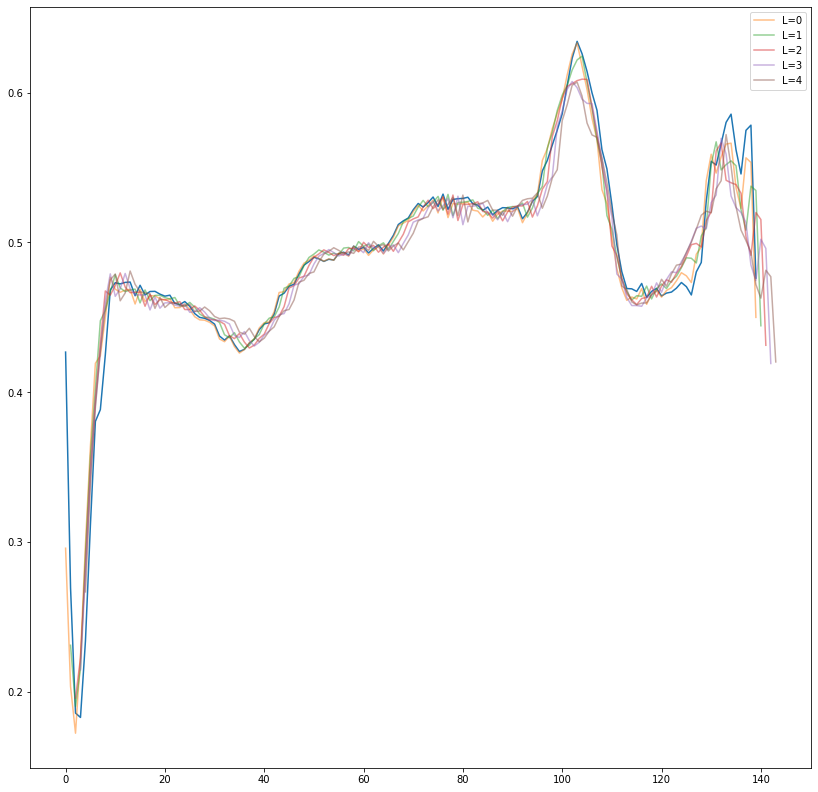

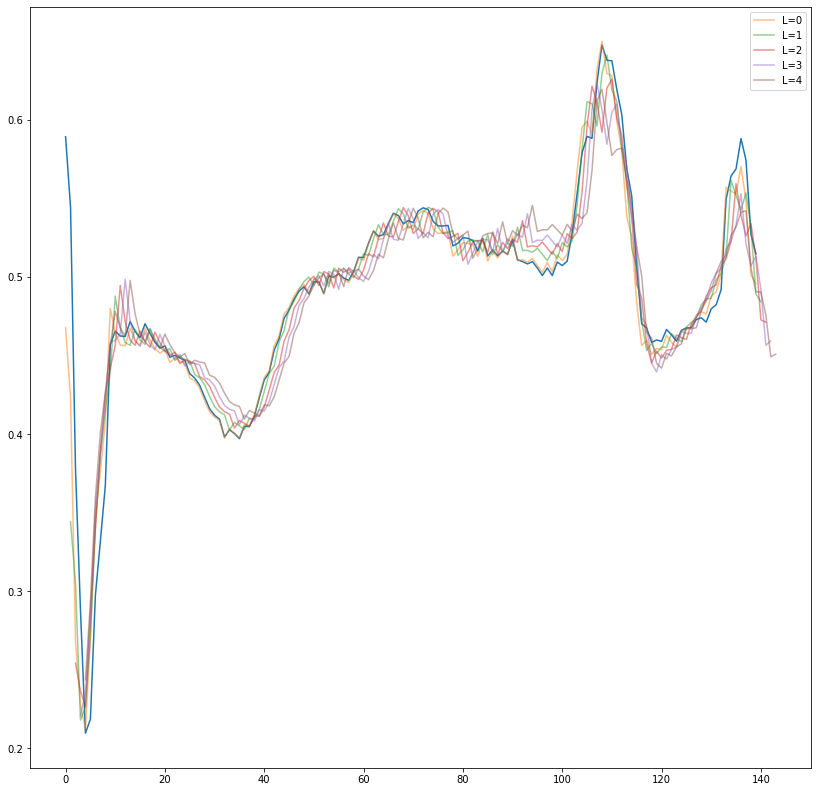

--------------------
(5, 140, 5)


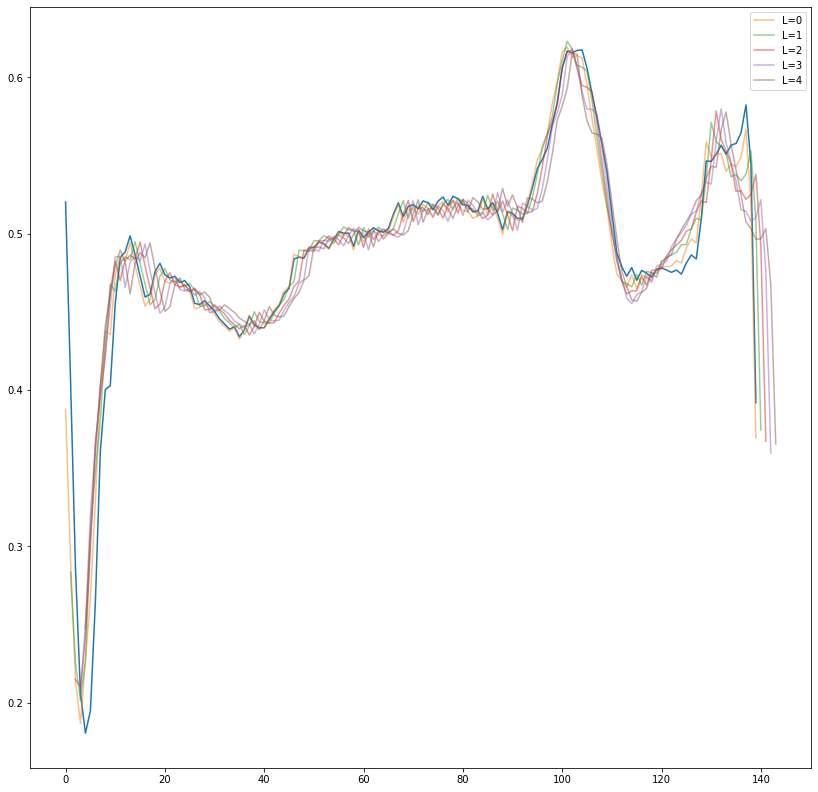

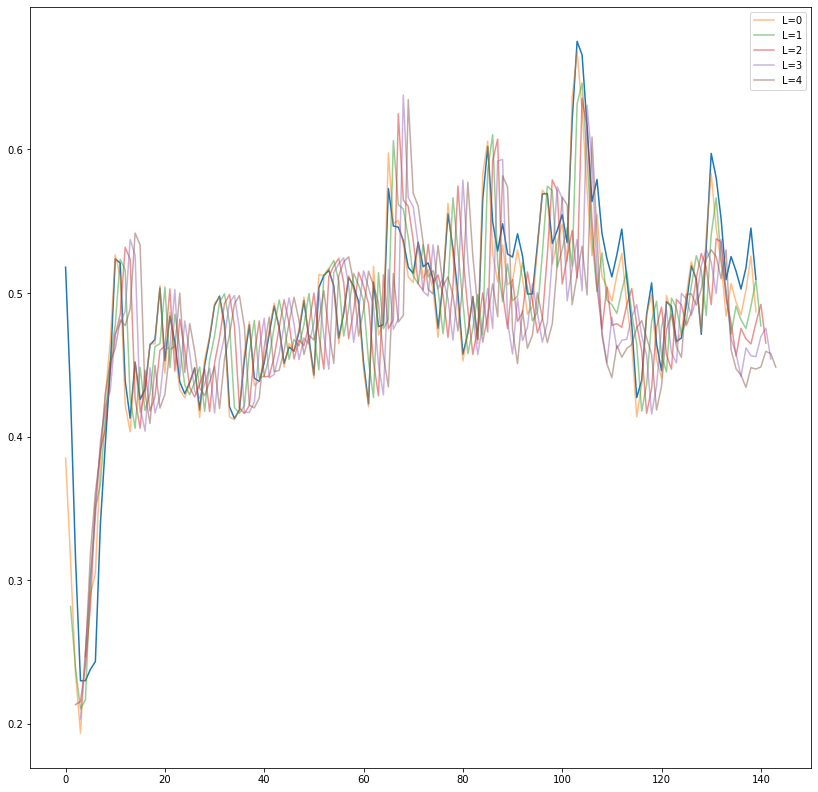

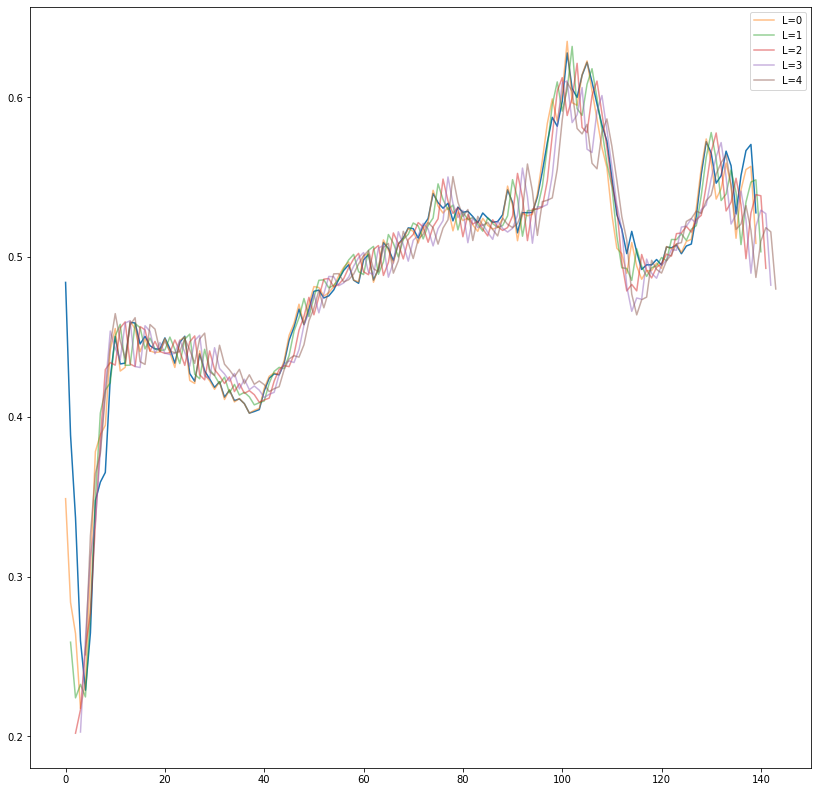

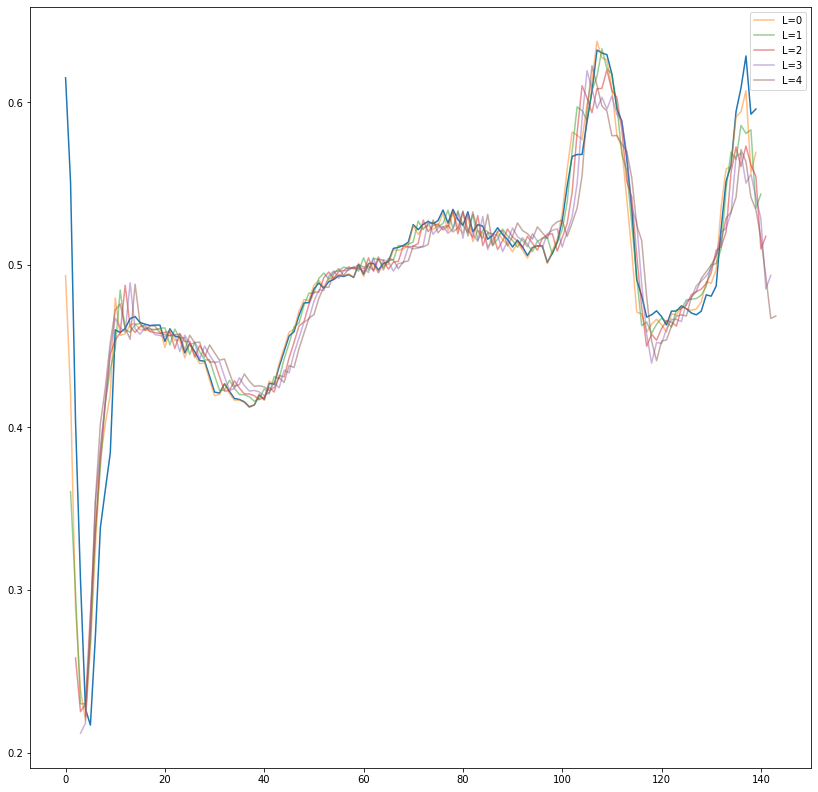

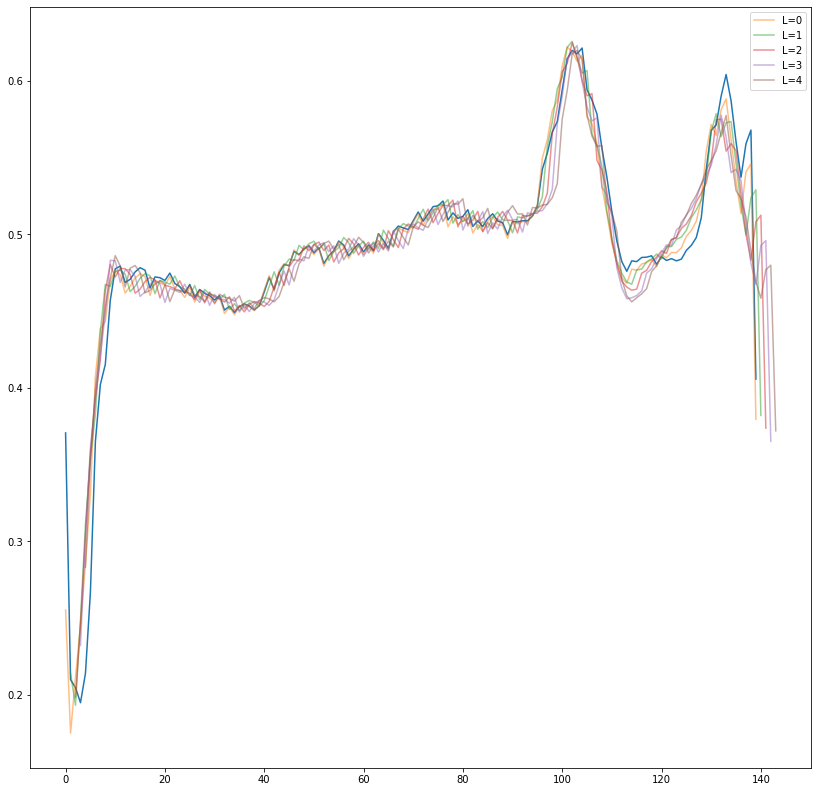

--------------------
(5, 140, 5)


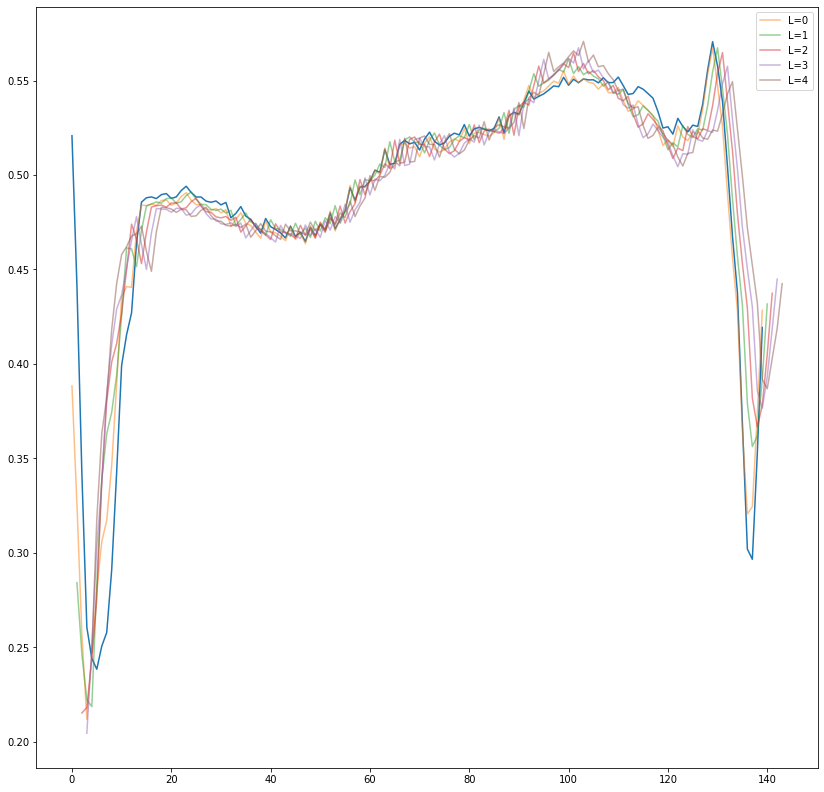

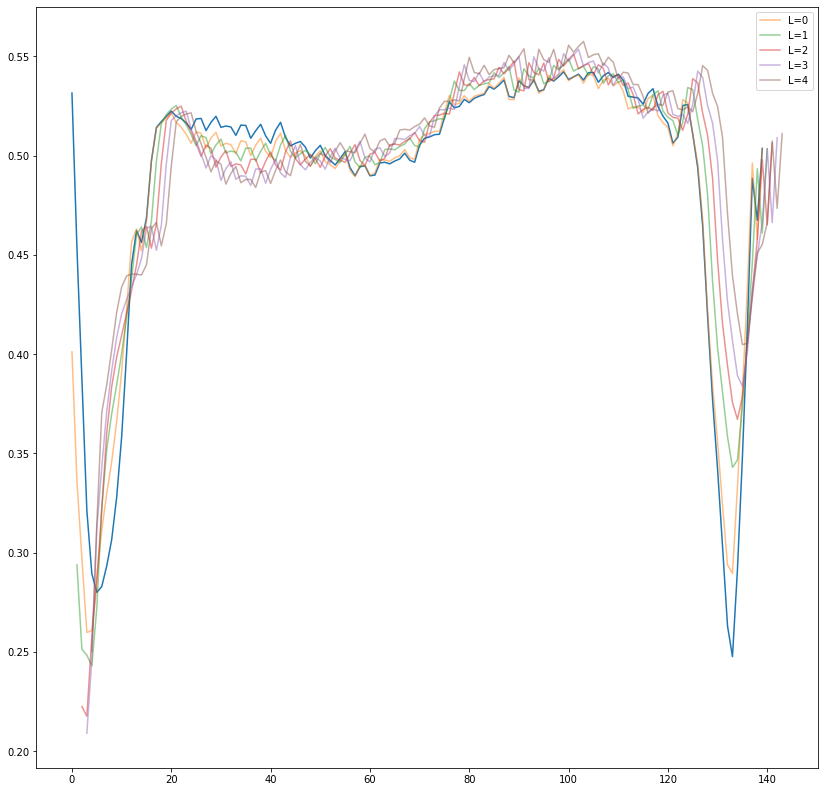

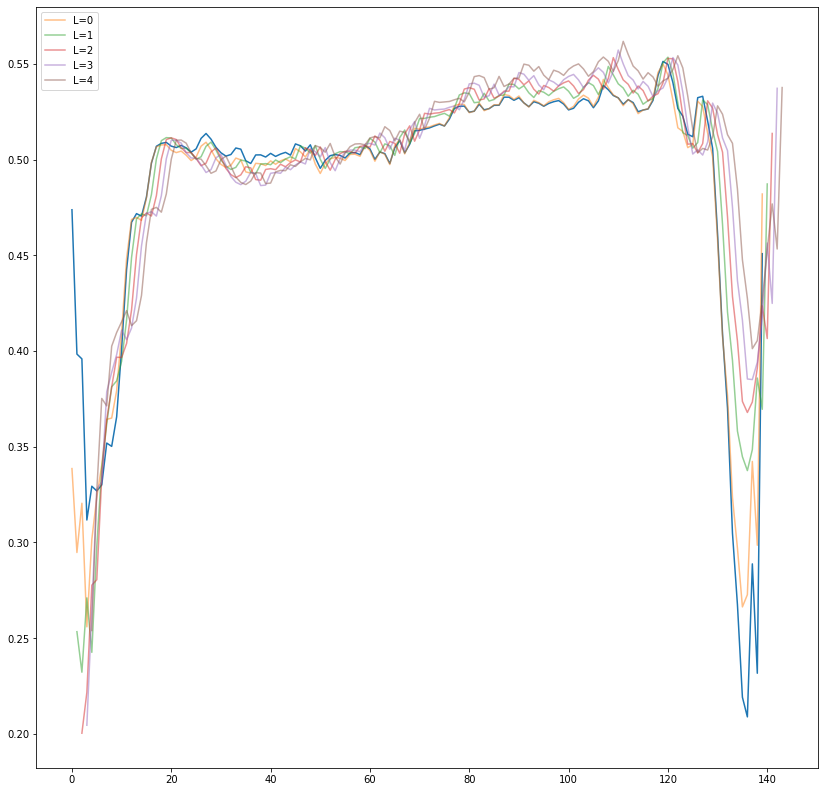

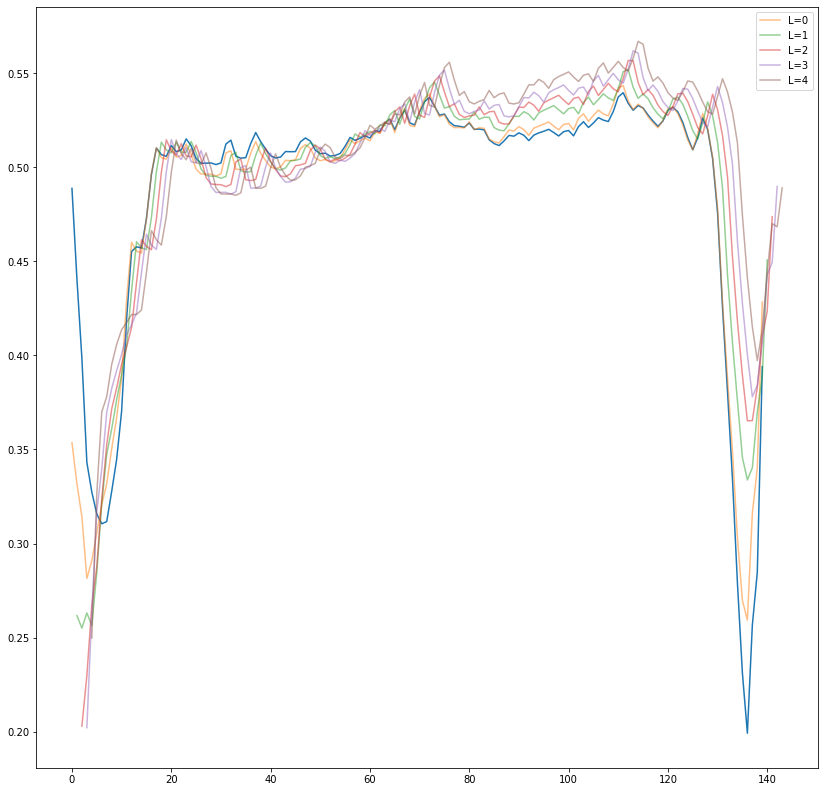

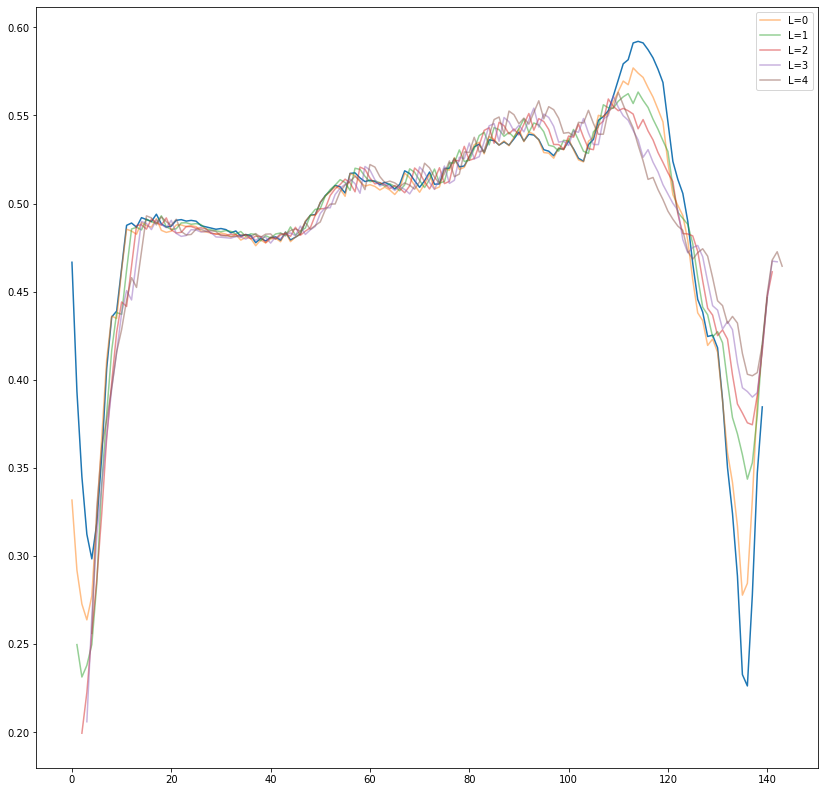

In [ ]:


EXAMPLE_COUNT = 5  
def print_model_predictions(model_path):
  model = torch.load(model_path, map_location=torch.device('cpu'))
  train_loader = DataLoader(dataset=train_normal, batch_size=EXAMPLE_COUNT, shuffle=False)
  valid_normal_loader = DataLoader(dataset=validation1_normal, batch_size=EXAMPLE_COUNT, shuffle=False)
  valid_anomaly_loader = DataLoader(dataset=validation_anomaly, batch_size=EXAMPLE_COUNT, shuffle=False)


  for target in [train_loader, valid_normal_loader, valid_anomaly_loader]:
    print('-'*20)
    batch = iter(target).next().float()
    outputs = model(batch)

    train_pred = outputs.detach().cpu().numpy()

    batch = batch.detach().cpu().numpy()
    print(train_pred.shape)
    _L = train_pred.shape[2]
    seq_len = train_pred.shape[1]

    for index in range(train_pred.shape[0]):
      plt.figure(figsize=(14, 14))
      plt.plot(batch[index])
      
      if 0:
        for i in range(0, seq_len - _L, _L//3):
          plt.plot(np.arange(i,i + _L)-1, train_pred[index][i], alpha=0.5)
      else:
        for l in range(0,_L):
          plt.plot(np.arange(0, seq_len)+l, train_pred[index, :, l], alpha=0.5,label=f"L={l}")
      plt.legend()
      plt.show()

  



print_model_predictions("/content/drive/My Drive/datasets/ad_lstm_ad.model")

In [ ]:
def error_estimation_on_val(model_path):
  bs = len(validation1_normal)
  valid_normal_loader = DataLoader(dataset=validation1_normal, batch_size=bs, shuffle=False)
  batch = iter(valid_normal_loader).next().float()
  model = torch.load(model_path, map_location=torch.device('cpu'))
  out = model(batch)
  err, m, var = model.error_estimation(out, batch)
  return model, m, var



model, MU, VAR = error_estimation_on_val("/content/drive/My Drive/datasets/ad_lstm_ad.model")
print(f"size of MU, VAR = {MU.size()}, {VAR.size()}")

In [ ]:
def likelihood_estimation():
  res = []
  for dataset in [validation2_normal, validation_anomaly]:
    bs = len(dataset)
    loader = DataLoader(dataset=dataset, batch_size=bs, shuffle=False)

    batch = iter(loader).next().float()
    out = model(batch)
    err, _, _ = model.error_estimation(out, batch) ##err (BS, seq-L, L)
    l_e = -L/2*torch.log(VAR) - torch.sum((err-MU.view(1,-1, 1)) **2, dim=2)/(2*VAR[None,:])
    print(l_e.size())

    l_e = l_e.detach().cpu().numpy()
    seq_len = l_e.shape[1]

    plt.figure(figsize=(14, 14))
    for index in range(5):
      plt.plot(l_e[index])
    plt.show()

    anomaly_score = np.min(l_e, axis=1)

    res.append((l_e, anomaly_score))
    print("AS: ", anomaly_score.shape)
  return res







est_and_as = likelihood_estimation()

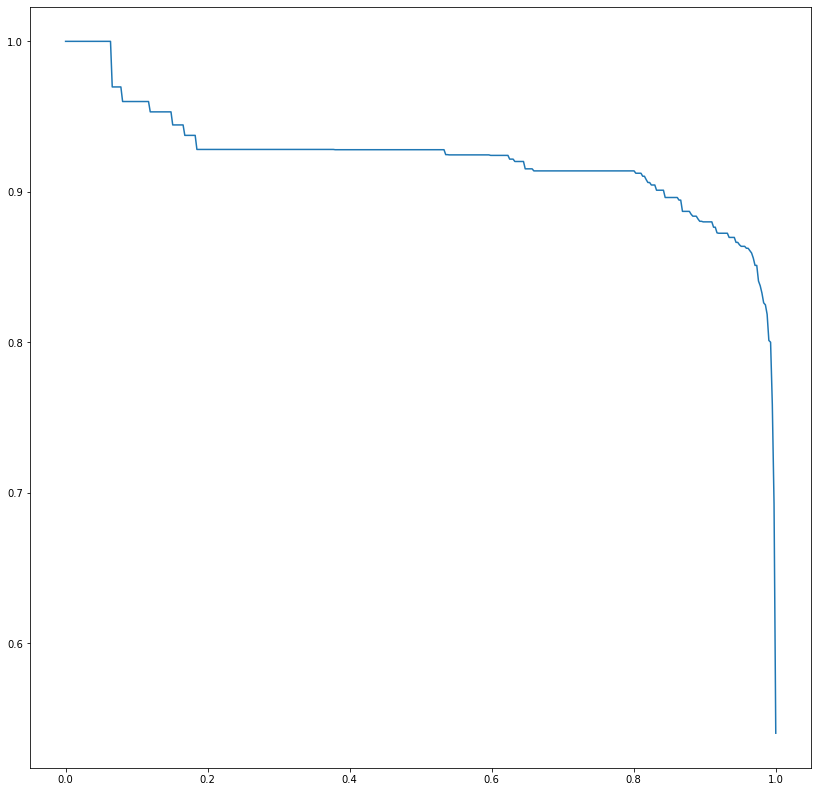

beta=0.1 F_beta=0.9212027820582234, Threshold=-40.38228988647461, Precision=0.9279661016949152, recall=0.5328467153284672
beta=0.2 F_beta=0.9089363510785251, Threshold=-15.407349586486816, Precision=0.9138888888888889, recall=0.8004866180048662
beta=0.3 F_beta=0.9033225018262425, Threshold=-15.407349586486816, Precision=0.9138888888888889, recall=0.8004866180048662
beta=0.4 F_beta=0.896740644442381, Threshold=-14.592660903930664, Precision=0.9123287671232877, recall=0.8102189781021898
beta=0.5 F_beta=0.8898984500267236, Threshold=-14.592660903930664, Precision=0.9123287671232877, recall=0.8102189781021898
beta=0.6 F_beta=0.8877408545099132, Threshold=-7.325584411621094, Precision=0.88, recall=0.9099756690997567
beta=0.7 F_beta=0.8925673728749299, Threshold=-4.867574691772461, Precision=0.8624454148471615, recall=0.9610705596107056
beta=0.8 F_beta=0.8984244979474092, Threshold=-4.867574691772461, Precision=0.8624454148471615, recall=0.9610705596107056
beta=0.9 F_beta=0.9039639707639859,

In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_curve
def precisiion_recall_curve(score, y, draw=True):
    sorted_indices = np.argsort(score)#[::-1]
    sorted_labels = y[sorted_indices]
    #print(sorted_labels)
    tp_fp_thresholds = np.where((sorted_labels == 1).reshape(-1))[0] + 1
    tp_fn = len(tp_fp_thresholds)

    tp = np.arange(tp_fn) + 1
    #precision = (tp / tp_fp_thresholds)[::-1]
    recall = np.insert(tp / tp_fn, 0, 0)
    precision = np.insert((tp / tp_fp_thresholds)[::-1], -1, 1)

    #p = np.where(np.diff(precision) > 0)[0]
    #while(len(p)> 0):
    #    precision[p] = precision[p+1]
    #    p = np.where(np.diff(precision) > 0)[0]
    precision = np.maximum.accumulate(precision)[::-1]

    #AP = (np.diff(recall) * precision).sum() + recall[0]*precision[0]
    AP = np.trapz(precision, recall)

    pr_rec1 = np.stack((precision, recall), axis=1)  # np.array(pr_rec)
    if draw:
        d = pd.DataFrame(pr_rec1, columns=['precision', 'recall'])
        plt.figure(figsize=(14, 14))
        plt.plot(pr_rec1[:,1], pr_rec1[:,0])

        plt.show()
    #print(score[sorted_indices][thresholds])
    return pr_rec1, score[sorted_indices][tp_fp_thresholds-1]


anomaly_score_full = np.append(est_and_as[0][1], est_and_as[1][1])

#1 - нормальные, код из knn, поэтому так (в KKN чем выше AS, те аномальнее, тут наоборот)
y = np.append(np.zeros(est_and_as[0][1].shape[0]), np.ones(est_and_as[1][1].shape[0]))
prc, edges = precisiion_recall_curve(anomaly_score_full, y)
for beta in range(10,100,10):
  beta = beta/100
  beta_sq = beta**2
  Fbeta_score = [(1 + beta_sq) * pr*rec/(pr*beta_sq+rec) for pr, rec in prc]
  F_max = max(Fbeta_score)
  i_max = Fbeta_score.index(F_max)
  threshold = edges[i_max]
  prec, rec = prc[i_max]
  print(f"beta={beta} F_beta={F_max}, Threshold={threshold}, Precision={prec}, recall={rec}")

beta=0.2 F_beta=0.9089363510785251, Threshold=-15.407349586486816, Precision=0.9138888888888889, recall=0.8004866180048662
torch.Size([411, 140, 1])
torch.Size([411, 140, 5])
[  5   6   7 ... 137 138 139] 140
[  0   0   0 ... 410 410 410]
[  4   5   6 ... 132 133 134]
[0 0 0 ... 4 4 4]
err torch.Size([411, 135, 5])
torch.Size([411, 135])
AS:  (411,)
torch.Size([411, 140, 1])
torch.Size([411, 140, 5])
[  5   6   7 ... 137 138 139] 140
[  0   0   0 ... 410 410 410]
[  4   5   6 ... 132 133 134]
[0 0 0 ... 4 4 4]
err torch.Size([411, 135, 5])
torch.Size([411, 135])
AS:  (411,)
torch.Size([411, 140, 1])
torch.Size([411, 140, 5])
[  5   6   7 ... 137 138 139] 140
[  0   0   0 ... 410 410 410]
[  4   5   6 ... 132 133 134]
[0 0 0 ... 4 4 4]
err torch.Size([411, 135, 5])
torch.Size([411, 135])
AS:  (411,)
TP=330 FP=62 FN=81 TN=760
confusion matrix:
[[330  62]
 [ 81 760]]

conf matrix is percent: 
[[0.84183673 0.15816327]
 [0.09631391 0.90368609]]

precision=0.8418367346938775 recall=0.8029197

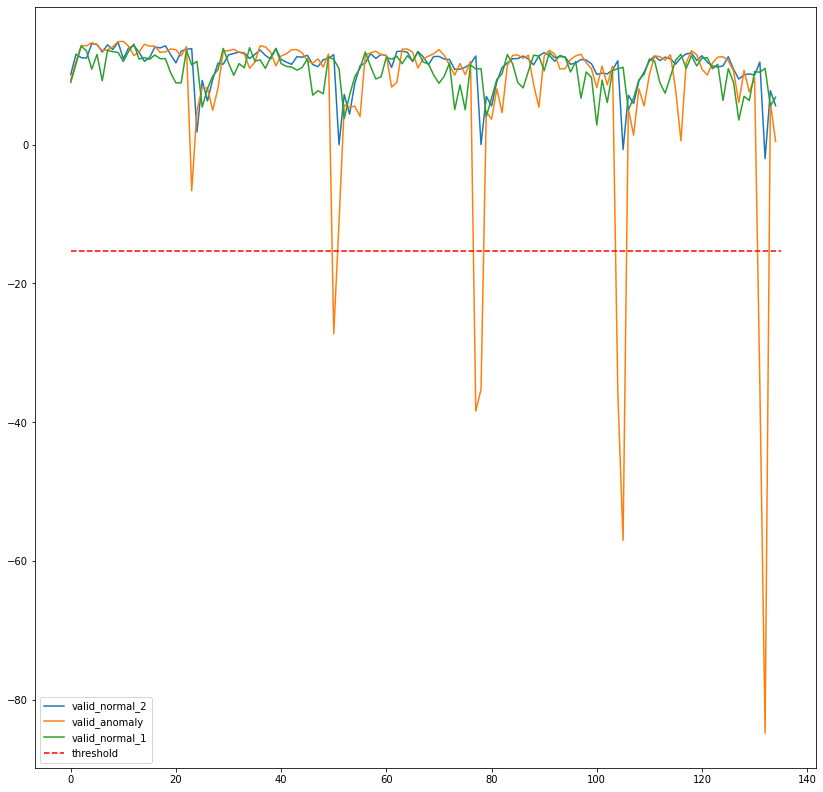

In [ ]:
beta=0.2
beta_sq = beta**2
Fbeta_score = [(1 + beta_sq) * pr*rec/(pr*beta_sq+rec) for pr, rec in prc]
F_max = max(Fbeta_score)
i_max = Fbeta_score.index(F_max)
threshold = edges[i_max]
prec, rec = prc[i_max]
print(f"beta={beta} F_beta={F_max}, Threshold={threshold}, Precision={prec}, recall={rec}")

def result_validation_dataset_with_threshold():
  res = []
  plt.figure(figsize=(14, 14))
  names = ["valid_normal_2", "valid_anomaly","valid_normal_1"]
  for j, dataset in enumerate([ validation2_normal, validation_anomaly, validation1_normal]):
    bs = len(dataset)
    loader = DataLoader(dataset=dataset, batch_size=bs, shuffle=False)

    batch = iter(loader).next().float()
    out = model(batch)
    err, _, _ = model.error_estimation(out, batch) ##err (BS, seq-L, L)
    l_e = -L/2*torch.log(VAR) - torch.sum((err-MU.view(1,-1, 1)) **2, dim=2)/(2*VAR[None,:])
    print(l_e.size())

    l_e = l_e.detach().cpu().numpy()
    seq_len = l_e.shape[1]

    
    for index in range(1):
      plt.plot(l_e[index + 11], label=names[j])

    anomaly_score = np.min(l_e, axis=1)
    res.append(anomaly_score)
    print("AS: ", anomaly_score.shape)

  y = np.zeros(res[0].shape[0])
  res[0] = np.append(res[0], res[1])
  y = np.append(y, np.ones(res[1].shape[0]))
  res[0] = np.append(res[0],res[2])
  y = np.append(y, np.zeros(res[2].shape[0]))

  labels = np.zeros(y.shape[0])
  labels[res[0] <= threshold] = 1
  labels[y == 1] += 2 # 0 - TN, 1 - FP, 2 - FN, 3 - TP
  tp, fp, fn, tn = (labels == 3).sum(), (labels == 1).sum(), (labels == 2).sum(), (labels == 0).sum()

  print(f"TP={tp} FP={fp} FN={fn} TN={tn}")
  confusion_matrix = np.array([[tp, fp],[fn, tn]])
  print(f"confusion matrix:\n{confusion_matrix}\n")
  print(f"conf matrix is percent: \n{confusion_matrix / confusion_matrix.sum(axis=1).reshape(-1,1)}\n")
  print(f"precision={tp/(tp+fp)} recall={tp/(tp+fn)}")
  plt.plot([0,135],[threshold,threshold], 'r--',label="threshold")
  plt.legend()
  plt.show()

result_validation_dataset_with_threshold()

torch.Size([103, 140, 1])
torch.Size([103, 140, 5])
[  5   6   7 ... 137 138 139] 140
[  0   0   0 ... 102 102 102]
[  4   5   6 ... 132 133 134]
[0 0 0 ... 4 4 4]
err torch.Size([103, 135, 5])
torch.Size([103, 135])
AS:  (103,)
torch.Size([103, 140, 1])
torch.Size([103, 140, 5])
[  5   6   7 ... 137 138 139] 140
[  0   0   0 ... 102 102 102]
[  4   5   6 ... 132 133 134]
[0 0 0 ... 4 4 4]
err torch.Size([103, 135, 5])
torch.Size([103, 135])
AS:  (103,)
TP=82 FP=7 FN=21 TN=96
confusion matrix:
[[82  7]
 [21 96]]

conf matrix is percent: 
[[0.92134831 0.07865169]
 [0.17948718 0.82051282]]

precision=0.9213483146067416 recall=0.7961165048543689


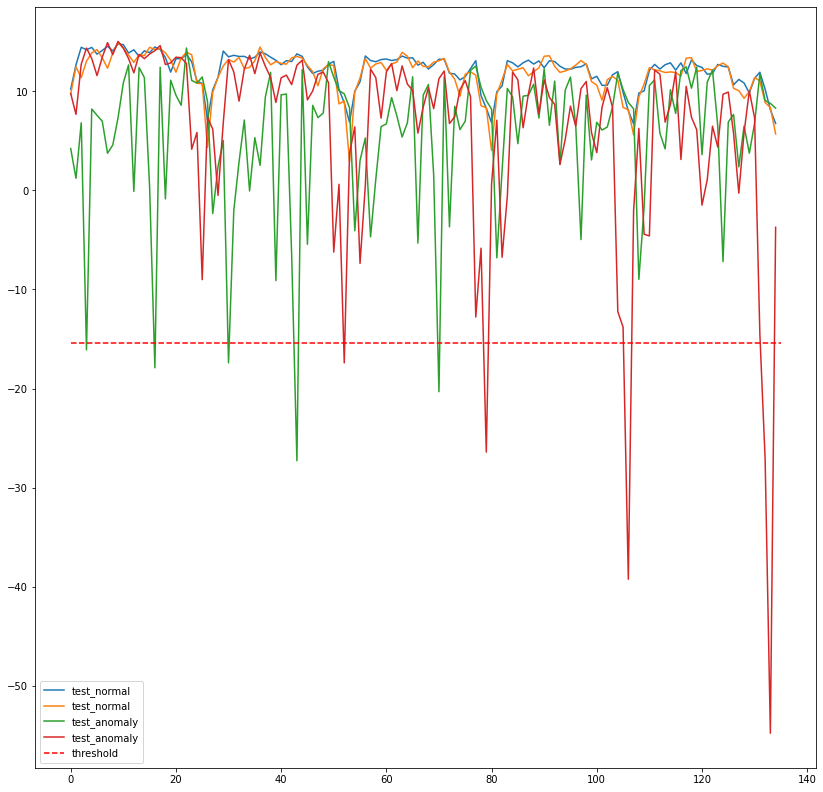

In [ ]:
def result_test_dataset_with_threshold():

  res = []
  plt.figure(figsize=(14, 14))
  names = ["test_normal", "test_anomaly"]
  for j, dataset in enumerate([ test_normal, test_anomaly]):
    bs = len(dataset)
    loader = DataLoader(dataset=dataset, batch_size=bs, shuffle=False)

    batch = iter(loader).next().float()
    out = model(batch)
    err, _, _ = model.error_estimation(out, batch) ##err (BS, seq-L, L)
    l_e = -L/2*torch.log(VAR) - torch.sum((err-MU.view(1,-1, 1)) **2, dim=2)/(2*VAR[None,:])
    print(l_e.size())

    l_e = l_e.detach().cpu().numpy()
    seq_len = l_e.shape[1]

    
    for index in range(2):
      plt.plot(l_e[index + 11], label=names[j])

    anomaly_score = np.min(l_e, axis=1)
    res.append(anomaly_score)
    print("AS: ", anomaly_score.shape)

  y = np.zeros(res[0].shape[0])
  res[0] = np.append(res[0], res[1])
  y = np.append(y, np.ones(res[1].shape[0]))
  #res[0] = np.append(res[0],res[2])
  #y = np.append(y, np.zeros(res[2].shape[0]))

  labels = np.zeros(y.shape[0])
  labels[res[0] <= threshold] = 1
  labels[y == 1] += 2 # 0 - TN, 1 - FP, 2 - FN, 3 - TP
  tp, fp, fn, tn = (labels == 3).sum(), (labels == 1).sum(), (labels == 2).sum(), (labels == 0).sum()

  print(f"TP={tp} FP={fp} FN={fn} TN={tn}")
  confusion_matrix = np.array([[tp, fp],[fn, tn]])
  print(f"confusion matrix:\n{confusion_matrix}\n")
  print(f"conf matrix is percent: \n{confusion_matrix / confusion_matrix.sum(axis=1).reshape(-1,1)}\n")
  print(f"precision={tp/(tp+fp)} recall={tp/(tp+fn)}")
  plt.plot([0,135],[threshold,threshold], 'r--',label="threshold")
  plt.legend()
  plt.show()

result_test_dataset_with_threshold()